In [1]:
import yaml

import sys
sys.path.append('/sdf/data/neutrino/software/spine/src')

from spine.driver import Driver
from spine.vis import Drawer

%matplotlib inline

cfg = '''
base:
  verbosity: info
build:
  mode: both
  fragments: false
  particles: true
  interactions: true
  units: cm
io:
  reader:
    file_keys: DATA_PATH
    name: hdf5
'''.replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.*.LARCV_spine.h5')

#replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.00025[3-5][0-9].LARCV_spine.h5')
#replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.*.LARCV_spine.h5')

driver = Driver(yaml.safe_load(cfg))

Welcome to JupyROOT 6.26/16

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome054 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765395938}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.*.LARCV_spine.h5,
    name: hdf5}
build: {mode: both, fragments: false, particles: true, interactions: true, units: cm}

Will load 99 file(s):
 - /sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.0002459.LARCV_spine

# Data process

In [2]:
# This cell processes all data for values relevant to purity

import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
from time import sleep, time
from spine.utils.geo import Geometry
from data_process_modules import extract_particle_features, compute_shower_dqdx, pca_analysis
import pickle
import os

# Define data save path
data_save_path = '/sdf/home/l/liuty/NuEEL/upload/data/cut_full_spill_processed_data.pkl'

# Check if processed data already exists
if os.path.exists(data_save_path):
    print(f"Loading processed data from {data_save_path}...")
    with open(data_save_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    # Load all variables
    interaction_count = saved_data['interaction_count']
    file_index = saved_data['file_index']
    index = saved_data['index']
    event_id = saved_data['event_id']
    true_id = saved_data['true_id']
    true_inter_id = saved_data['true_inter_id']
    reco_id = saved_data['reco_id']
    indices_NUEEL = saved_data['indices_NUEEL']
    current_type = saved_data['current_type']
    target = saved_data['target']
    interaction_mode = saved_data['interaction_mode']
    interaction_type = saved_data['interaction_type']
    true_energy = saved_data['true_energy']
    true_topology = saved_data['true_topology']
    true_pdg = saved_data['true_pdg']
    true_dedx_list = saved_data['true_dedx_list']
    true_particle_info = saved_data['true_particle_info']
    true_pca_variables = saved_data['true_pca_variables']
    reco_vertex = saved_data['reco_vertex']
    reco_topology = saved_data['reco_topology']
    reco_dedx_list = saved_data['reco_dedx_list']
    reco_particle_info = saved_data['reco_particle_info']
    reco_pca_variables = saved_data['reco_pca_variables']
    
    print(f"Data loaded successfully! Total interactions: {interaction_count}")
    print(f"NUEEL indices: {indices_NUEEL}")
    
else:
    print("Processing data from scratch...")
    
    interaction_count = 0

    # General info
    file_index = []
    index = []
    event_id = []
    true_id = []
    true_inter_id = []
    reco_id = []
    indices_NUEEL = []

    # Detailed info for cuts
        # truth info
    current_type = []
    target = []
    interaction_mode = []
    interaction_type = []
    true_energy = []
    true_topology = []
    true_pdg = []
    true_dedx_list = []
    true_particle_info = []
    true_pca_variables = []

        # reco info
    reco_vertex = []
    reco_topology = []
    reco_dedx_list = []
    reco_particle_info = [] # shape: [[{info of particle 1 of interaction 1}], [{info of particle 1 of interaction 2}, {info of particle 2 of interaction 2}], ...]
    reco_pca_variables = []

    geo = Geometry('ndlar')

    for data in tqdm(driver):
        for reco, truth in data['interaction_matches_r2t']:
                
            file_index.append(data['file_index'])
            index.append(data['index'])
            event_id.append(data['run_info'].event)
            reco_id.append(reco.id)
            reco_top = reco.topology
            reco_topology.append(reco_top)
            reco_vertex.append(reco.vertex)
            reco_dedx = compute_shower_dqdx(reco)
            reco_dedx_list.append(reco_dedx)

            # collect particle info for each interaction
            info = []
            points = []
            for _, particle in enumerate(reco.particles):
                points.append(particle.points)
                info.append(extract_particle_features(particle))
            reco_particle_info.append(info)
            points_combined = np.vstack(points)
            reco_pca_variables.append(pca_analysis(points_combined))

            if truth is None:
                true_topology.append('')
                true_id.append('')
                current_type.append('')
                target.append('')
                interaction_mode.append('')
                interaction_type.append('')
                true_energy.append('')
                true_pdg.append('')
                true_inter_id.append('')
                true_particle_info.append([])
                true_dedx_list.append('')
                true_pca_variables.append('')

            else:
                cur_type = truth.current_type
                targ = truth.target
                inter_mode = truth.interaction_mode
                inter_type = truth.interaction_type
                energy = truth.energy_init
                true_top = truth.topology
                pdg = truth.pdg_code
                true_id.append(truth.id)
                current_type.append(cur_type)
                target.append(targ)
                interaction_mode.append(inter_mode)
                interaction_type.append(inter_type)
                true_energy.append(energy)
                true_topology.append(true_top)
                true_pdg.append(pdg)
                true_inter_id.append(truth.interaction_id)
                true_dedx = compute_shower_dqdx(truth)
                true_dedx_list.append(true_dedx)
                info = []
                points = []
                for _, particle in enumerate(truth.particles):
                    points.append(particle.points)
                    info.append(extract_particle_features(particle))
                true_particle_info.append(info)
                points_combined = np.vstack(points)
                true_pca_variables.append(pca_analysis(points_combined))
                if true_top == '1e' and inter_mode == 7:
                    indices_NUEEL.append(interaction_count)
                
            interaction_count += 1

    print('Total interactions analyzed: ', interaction_count)
    print('NUEEL indices:', indices_NUEEL)
    
    # Save processed data
    print(f"Saving processed data to {data_save_path}...")
    os.makedirs(os.path.dirname(data_save_path), exist_ok=True)
    
    data_to_save = {
        'interaction_count': interaction_count,
        'file_index': file_index,
        'index': index,
        'event_id': event_id,
        'true_id': true_id,
        'true_inter_id': true_inter_id,
        'reco_id': reco_id,
        'indices_NUEEL': indices_NUEEL,
        'current_type': current_type,
        'target': target,
        'interaction_mode': interaction_mode,
        'interaction_type': interaction_type,
        'true_energy': true_energy,
        'true_topology': true_topology,
        'true_pdg': true_pdg,
        'true_dedx_list': true_dedx_list,
        'true_particle_info': true_particle_info,
        'true_pca_variables': true_pca_variables,
        'reco_vertex': reco_vertex,
        'reco_topology': reco_topology,
        'reco_dedx_list': reco_dedx_list,
        'reco_particle_info': reco_particle_info,
        'reco_pca_variables': reco_pca_variables
    }
    
    with open(data_save_path, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print("Data saved successfully!")

  0%|          | 0/1252 [00:00<?, ?it/s]

Total interactions analyzed:  169325
NUEEL indices: [119160, 121949, 142548]


# Params

In [3]:
# ============================================================================
# Cut Parameters
# ============================================================================

# ============================================================================
# Cut Enable/Disable Switches
# ============================================================================
ENABLE_TOPOLOGY_CUT = True
ENABLE_FIDUCIAL_CUT = False
ENABLE_ANGLE_CUT = True
ENABLE_DEDX_CUT = True
ENABLE_ETHETA2_CUT = True
ENABLE_KE_CUT = True
ENABLE_PCA_CUT = True
ENABLE_PROXIMITY_CUT = True

# ============================================================================
# Cut Parameter Values
# ============================================================================

# Angle cut: maximum angle between particle and beam direction (degrees)
ANGLE_CUT_MAX = 7.0  # degrees

# Reco topology cut: allowed reconstruction topology types
RECO_TOPOLOGY_ALLOWED = ['1e', '1g']

# dE/dx cut: allowed range for initial dE/dx (MeV/cm)
DEDX_CUT_MIN = -1.2   # MeV/cm
DEDX_CUT_MAX = 2.5   # MeV/cm

# Eθ² cut: maximum value of kinetic energy × angle squared (MeV·rad²)
ETHETA2_CUT_MAX = 3.0  # MeV·rad²

# KE cut: minimum particle kinetic energy (MeV)
KE_CUT_MIN = 150.0  # MeV

# Fiducial volume margin (cm)
MARGIN_MODULE = 1.5  # cm
MARGIN_DETECTOR = 5.0  # cm

# DELTA_D cut: angular spread. Not in use.
DELTA_D_CUT_MAX = 999999999999
DELTA_D_CUT_MIN = -999999999999

"""PCA Cuts:"""
# PCA axis 1 wrt beam direction. Not in use (prefer start_dir angle cut).
PCA_PC1_ANGLE_MAX = 99999999999  # degrees

# Longitudinal spread (sqrt(λ1)) range
PCA_LONGITUDINAL_MIN = -2      # cm
PCA_LONGITUDINAL_MAX = 99960      # cm

# Major transverse spread (sqrt(λ2)/sqrt(λ1)) range
PCA_TRANSVERSE_MAJOR_MIN = 0.04      
PCA_TRANSVERSE_MAJOR_MAX = 9990.4      

# Minor transverse spread (sqrt(λ3)/sqrt(λ1)) range
PCA_TRANSVERSE_MINOR_MIN = 0.02      
PCA_TRANSVERSE_MINOR_MAX = 9990.2

# Distance threshold (cm)
PROXIMITY_DISTANCE_THRESHOLD = 0.5


print("=" * 60)
print("Cut Parameters Configuration")
print("=" * 60)
print("\nCut Switches:")
print(f"  Topology Cut: {'ENABLED' if ENABLE_TOPOLOGY_CUT else 'DISABLED'}")
print(f"  Fiducial Volume Cut: {'ENABLED' if ENABLE_FIDUCIAL_CUT else 'DISABLED'}")
print(f"  Angle Cut: {'ENABLED' if ENABLE_ANGLE_CUT else 'DISABLED'}")
print(f"  dE/dx Cut: {'ENABLED' if ENABLE_DEDX_CUT else 'DISABLED'}")
print(f"  Eθ² Cut: {'ENABLED' if ENABLE_ETHETA2_CUT else 'DISABLED'}")
print(f"  KE Cut: {'ENABLED' if ENABLE_KE_CUT else 'DISABLED'}")
print(f"  PCA Cut: {'ENABLED' if ENABLE_PCA_CUT else 'DISABLED'}")
print(f"  Proximity Cut: {'ENABLED' if ENABLE_PROXIMITY_CUT else 'DISABLED'}")
print("\nCut Parameter Values:")
print(f"  Angle cut: < {ANGLE_CUT_MAX}°")
print(f"  Reco topology: {RECO_TOPOLOGY_ALLOWED}")
print(f"  dE/dx range: [{DEDX_CUT_MIN}, {DEDX_CUT_MAX}] MeV/cm")
print(f"  Eθ² cut: < {ETHETA2_CUT_MAX} MeV·rad²")
print(f"  KE cut: > {KE_CUT_MIN} MeV")
print(f"  DELTA_D cut: [{DELTA_D_CUT_MIN}, {DELTA_D_CUT_MAX}] (Not in use)")
print(f"\nPCA Cuts:")
print(f"  PC1 angle: < {PCA_PC1_ANGLE_MAX}° (Not in use)")
print(f"  Longitudinal sqrt(λ1): [{PCA_LONGITUDINAL_MIN}, {PCA_LONGITUDINAL_MAX}] cm")
print(f"  Transverse major sqrt(λ2)/sqrt(λ1): [{PCA_TRANSVERSE_MAJOR_MIN}, {PCA_TRANSVERSE_MAJOR_MAX}]")
print(f"  Transverse minor sqrt(λ3)/sqrt(λ1): [{PCA_TRANSVERSE_MINOR_MIN}, {PCA_TRANSVERSE_MINOR_MAX}]")
print(f"\nProximity Cut:")
print(f"  Distance threshold: {PROXIMITY_DISTANCE_THRESHOLD} cm")
print("=" * 60)

Cut Parameters Configuration

Cut Switches:
  Topology Cut: ENABLED
  Fiducial Volume Cut: DISABLED
  Angle Cut: ENABLED
  dE/dx Cut: ENABLED
  Eθ² Cut: ENABLED
  KE Cut: ENABLED
  PCA Cut: ENABLED
  Proximity Cut: ENABLED

Cut Parameter Values:
  Angle cut: < 7.0°
  Reco topology: ['1e', '1g']
  dE/dx range: [-1.2, 2.5] MeV/cm
  Eθ² cut: < 3.0 MeV·rad²
  KE cut: > 150.0 MeV
  DELTA_D cut: [-999999999999, 999999999999] (Not in use)

PCA Cuts:
  PC1 angle: < 99999999999° (Not in use)
  Longitudinal sqrt(λ1): [-2, 99960] cm
  Transverse major sqrt(λ2)/sqrt(λ1): [0.04, 9990.4]
  Transverse minor sqrt(λ3)/sqrt(λ1): [0.02, 9990.2]

Proximity Cut:
  Distance threshold: 0.5 cm


# Cut 1: Topology

In [4]:
# Cut 1: topology

indices_after_topo_cut = []
indices_of_remaining_backgrounds = []

if ENABLE_TOPOLOGY_CUT:
    for i in range(len(reco_topology)):
        if reco_topology[i] in RECO_TOPOLOGY_ALLOWED: # topology must be 1e or 1g
            flag_non_em_particle_exist = False
            for j, info in enumerate(reco_particle_info[i]):
                if info['particle_pid'] > 100: # not e or g
                    flag_non_em_particle_exist = True
                    break
            if not flag_non_em_particle_exist:
                indices_after_topo_cut.append(i)
    
    print(f"Topology Cut: ENABLED")
    print(f"Pass Topology cut: {len(indices_after_topo_cut)} / {len(reco_topology)}")
    print(f"Pass rate: {len(indices_after_topo_cut)/len(reco_topology)*100:.2f}%")
else:
    # If cut is disabled, pass all interactions
    indices_after_topo_cut = list(range(len(reco_topology)))
    print(f"Topology Cut: DISABLED (all {len(indices_after_topo_cut)} interactions passed)")

indices_of_remaining_backgrounds = indices_after_topo_cut.copy()

Topology Cut: ENABLED
Pass Topology cut: 3926 / 169325
Pass rate: 2.32%


# Cut 2: Fiducial Volume

## Cut

In [5]:
# Cut 2: Fiducial Volume cut
import numpy as np

indices_after_fiducial_cut = []

if ENABLE_FIDUCIAL_CUT:
    geo.define_containment_volumes(margin=MARGIN_MODULE, mode='module')
    geo1 = Geometry('ndlar')
    geo1.define_containment_volumes(margin=MARGIN_DETECTOR, mode='detector')

    # cathode surfaces at x = -300, -200, ..., 200, 300
    cathode_x = [-300, -200, -100, 0, 100, 200, 300]

    for i in indices_after_topo_cut:
        # Check if vertex is within fiducial volume
        if not geo.check_containment(reco_vertex[i]):
            continue
        if not geo1.check_containment(reco_vertex[i]):
            continue
        
        # Check if vertex x is too close to cathode surfaces
        vertex_x = reco_vertex[i][0]
        too_close_to_cathode = False
        for boundary_x in cathode_x:
            if abs(vertex_x - boundary_x) < MARGIN_MODULE:
                too_close_to_cathode = True
                break
        
        if not too_close_to_cathode:
            indices_after_fiducial_cut.append(i)

    # Print summary
    print("\n" + "=" * 60)
    print("Fiducial Volume Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_topo_cut)} interactions")
    print(f"Pass fiducial volume cut: {len(indices_after_fiducial_cut)} interactions")
    print(f"Pass rate: {len(indices_after_fiducial_cut)/len(indices_after_topo_cut)*100:.2f}%")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_fiducial_cut = indices_after_topo_cut.copy()
    print("\n" + "=" * 60)
    print("Fiducial Volume Cut: DISABLED")
    print(f"All {len(indices_after_fiducial_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_fiducial_cut.copy()


Fiducial Volume Cut: DISABLED
All 3926 interactions passed


## Vertex Distribution for True 1e Topology

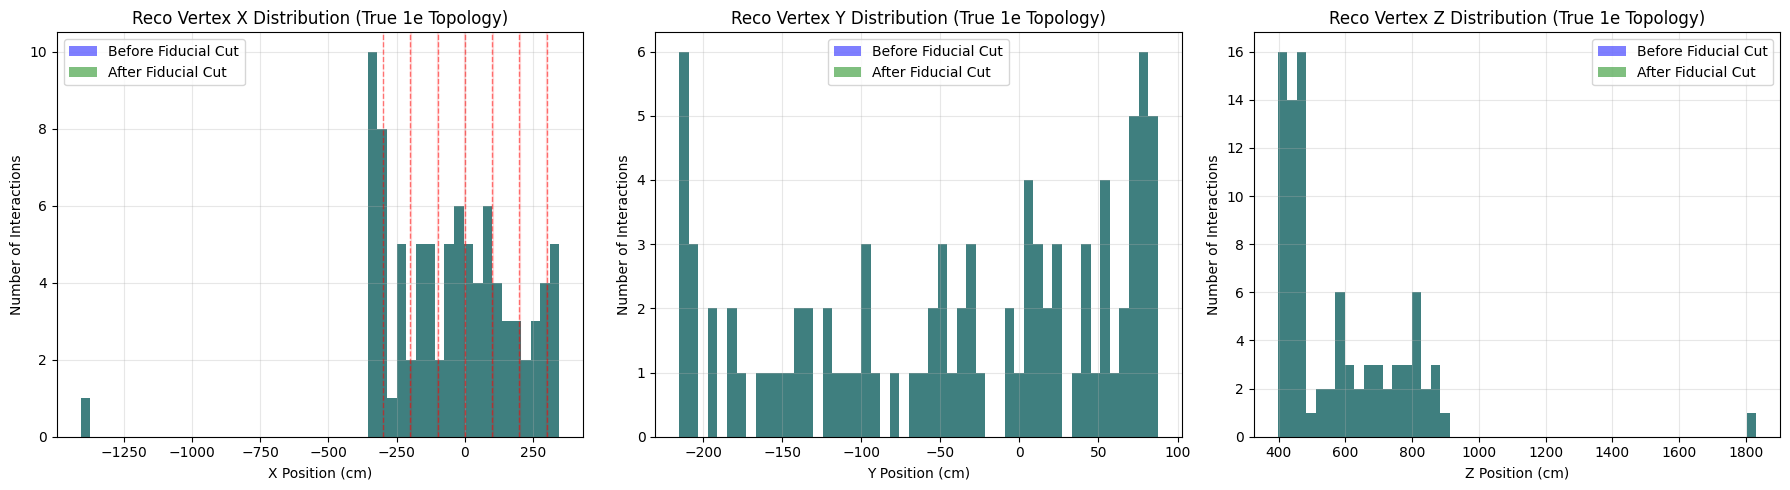


Vertex Distribution Statistics (True 1e Topology)

Before Fiducial Cut: 89 interactions
X range: [-1407.38, 346.15] cm
Y range: [-215.11, 87.44] cm
Z range: [396.49, 1830.50] cm

After Fiducial Cut: 89 interactions
X range: [-1407.38, 346.15] cm
Y range: [-215.11, 87.44] cm
Z range: [396.49, 1830.50] cm

Cathode positions (x): [-300, -200, -100, 0, 100, 200, 300]
Cathode avoidance margin: ±1.5 cm


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Collect vertex coordinates for true 1e topology interactions
vertex_x_before_cut = []
vertex_y_before_cut = []
vertex_z_before_cut = []

vertex_x_after_cut = []
vertex_y_after_cut = []
vertex_z_after_cut = []

for i in indices_after_topo_cut:
    if true_topology[i] == '1e':
        vertex = reco_vertex[i]
        vertex_x_before_cut.append(vertex[0])
        vertex_y_before_cut.append(vertex[1])
        vertex_z_before_cut.append(vertex[2])

for i in indices_after_fiducial_cut:
    if true_topology[i] == '1e':
        vertex = reco_vertex[i]
        vertex_x_after_cut.append(vertex[0])
        vertex_y_after_cut.append(vertex[1])
        vertex_z_after_cut.append(vertex[2])

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# X distribution with cathode positions
axes[0].hist(vertex_x_before_cut, bins=50, alpha=0.5, label='Before Fiducial Cut', color='blue')
axes[0].hist(vertex_x_after_cut, bins=50, alpha=0.5, label='After Fiducial Cut', color='green')
# Mark cathode positions
cathode_x = [-300, -200, -100, 0, 100, 200, 300]
for cathode_pos in cathode_x:
    axes[0].axvline(cathode_pos, color='red', linestyle='--', alpha=0.5, linewidth=1)
    # Mark margin regions
    axes[0].axvspan(cathode_pos - MARGIN_MODULE, cathode_pos + MARGIN_MODULE, alpha=0.1, color='red')
axes[0].set_xlabel('X Position (cm)')
axes[0].set_ylabel('Number of Interactions')
axes[0].set_title('Reco Vertex X Distribution (True 1e Topology)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Y distribution
axes[1].hist(vertex_y_before_cut, bins=50, alpha=0.5, label='Before Fiducial Cut', color='blue')
axes[1].hist(vertex_y_after_cut, bins=50, alpha=0.5, label='After Fiducial Cut', color='green')
axes[1].set_xlabel('Y Position (cm)')
axes[1].set_ylabel('Number of Interactions')
axes[1].set_title('Reco Vertex Y Distribution (True 1e Topology)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Z distribution
axes[2].hist(vertex_z_before_cut, bins=50, alpha=0.5, label='Before Fiducial Cut', color='blue')
axes[2].hist(vertex_z_after_cut, bins=50, alpha=0.5, label='After Fiducial Cut', color='green')
axes[2].set_xlabel('Z Position (cm)')
axes[2].set_ylabel('Number of Interactions')
axes[2].set_title('Reco Vertex Z Distribution (True 1e Topology)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "=" * 60)
print("Vertex Distribution Statistics (True 1e Topology)")
print("=" * 60)
print(f"\nBefore Fiducial Cut: {len(vertex_x_before_cut)} interactions")
if len(vertex_x_before_cut) > 0:
    print(f"X range: [{min(vertex_x_before_cut):.2f}, {max(vertex_x_before_cut):.2f}] cm")
    print(f"Y range: [{min(vertex_y_before_cut):.2f}, {max(vertex_y_before_cut):.2f}] cm")
    print(f"Z range: [{min(vertex_z_before_cut):.2f}, {max(vertex_z_before_cut):.2f}] cm")

print(f"\nAfter Fiducial Cut: {len(vertex_x_after_cut)} interactions")
if len(vertex_x_after_cut) > 0:
    print(f"X range: [{min(vertex_x_after_cut):.2f}, {max(vertex_x_after_cut):.2f}] cm")
    print(f"Y range: [{min(vertex_y_after_cut):.2f}, {max(vertex_y_after_cut):.2f}] cm")
    print(f"Z range: [{min(vertex_z_after_cut):.2f}, {max(vertex_z_after_cut):.2f}] cm")
else:
    print("No interactions passed the fiducial cut")

print(f"\nCathode positions (x): {cathode_x}")
print(f"Cathode avoidance margin: ±{MARGIN_MODULE} cm")
print("=" * 60)

# Cut 3: Angle Cut

## Distrubution

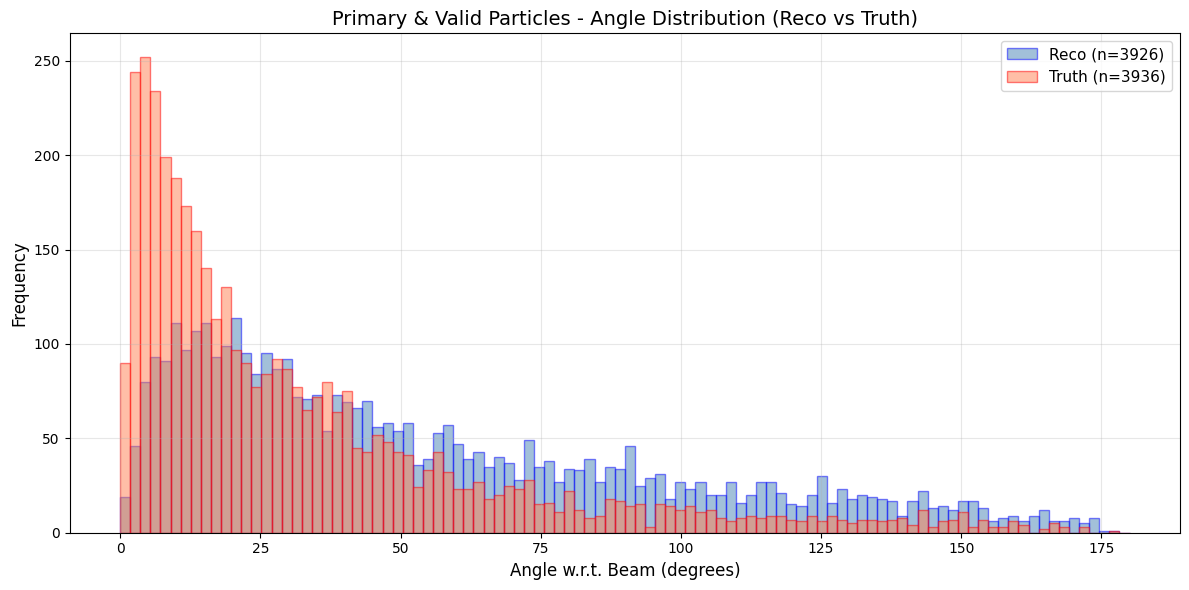

RECO:
  Total particles: 3926
  Mean: 54.81°
  Median: 42.44°
  Std: 42.47°

TRUTH:
  Total particles: 3936
  Mean: 33.08°
  Median: 20.64°
  Std: 34.45°


In [7]:
# Extract angles for all primary and valid particles (reco and truth)
import matplotlib.pyplot as plt

angle_list_reco = []  # Reco primary and valid particles
angle_list_truth = []  # Truth primary and valid particles

# Collect reco angles
for i, particle_list in enumerate(reco_particle_info):
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            angle = particle_dict['angle_wrt_beam']
            angle_list_reco.append(angle)

# Collect truth angles
for i, particle_list in enumerate(true_particle_info):
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            angle = particle_dict['angle_wrt_beam']
            angle_list_truth.append(angle)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(angle_list_reco, bins=100, range=(0, 180), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(angle_list_reco)})')
ax.hist(angle_list_truth, bins=100, range=(0, 180), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(angle_list_truth)})')

ax.set_xlabel('Angle w.r.t. Beam (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Primary & Valid Particles - Angle Distribution (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 60)
print("RECO:")
print(f"  Total particles: {len(angle_list_reco)}")
print(f"  Mean: {np.mean(angle_list_reco):.2f}°")
print(f"  Median: {np.median(angle_list_reco):.2f}°")
print(f"  Std: {np.std(angle_list_reco):.2f}°")

print("\nTRUTH:")
print(f"  Total particles: {len(angle_list_truth)}")
print(f"  Mean: {np.mean(angle_list_truth):.2f}°")
print(f"  Median: {np.median(angle_list_truth):.2f}°")
print(f"  Std: {np.std(angle_list_truth):.2f}°")
print("=" * 60)

In [8]:
# Export angle distribution data to CSV
import pandas as pd
import os

# Create data directory if not exists
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

# Export angle data
angle_data = pd.DataFrame({
    'angle_reco': angle_list_reco,
})
angle_data.to_csv(f'{data_dir}/full_spill_angle_reco.csv', index=False)

angle_data_truth = pd.DataFrame({
    'angle_truth': angle_list_truth,
})
angle_data_truth.to_csv(f'{data_dir}/full_spill_angle_truth.csv', index=False)

print(f"Exported angle data to {data_dir}")
print(f"  - full_spill_angle_reco.csv: {len(angle_list_reco)} entries")
print(f"  - full_spill_angle_truth.csv: {len(angle_list_truth)} entries")

Exported angle data to ./data
  - full_spill_angle_reco.csv: 3926 entries
  - full_spill_angle_truth.csv: 3936 entries


## Cut

In [9]:
# Cut 3: Angle cut
import numpy as np
import matplotlib.pyplot as plt

indices_after_angle_cut = []

warning_zero_particles = 0
warning_multiple_particles = 0

if ENABLE_ANGLE_CUT:
    for i in indices_after_fiducial_cut:
        particle_list = reco_particle_info[i]
        
        # Warnings if not exactly 1 primary valid particle
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_angle_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_angle_cut.append(i)
            continue
        
        for j in range(len(reco_particle_info[i])):
             if reco_particle_info[i][j]['primary'] and reco_particle_info[i][j]['valid']:
                angle = reco_particle_info[i][j]['angle_wrt_beam']
                if angle < ANGLE_CUT_MAX:
                        indices_after_angle_cut.append(i)
                break

    # Print summary
    print("\n" + "=" * 60)
    print("Angle Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_fiducial_cut)} interactions")
    print(f"Pass angle cut: {len(indices_after_angle_cut)} interactions")
    print(f"Pass rate: {len(indices_after_angle_cut)/len(indices_after_fiducial_cut)*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_angle_cut = indices_after_fiducial_cut.copy()
    print("\n" + "=" * 60)
    print("Angle Cut: DISABLED")
    print(f"All {len(indices_after_angle_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_angle_cut.copy()


Angle Cut: ENABLED
After last cut: 3926 interactions
Pass angle cut: 225 interactions
Pass rate: 5.73%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 4: dE/dx

## Disribution

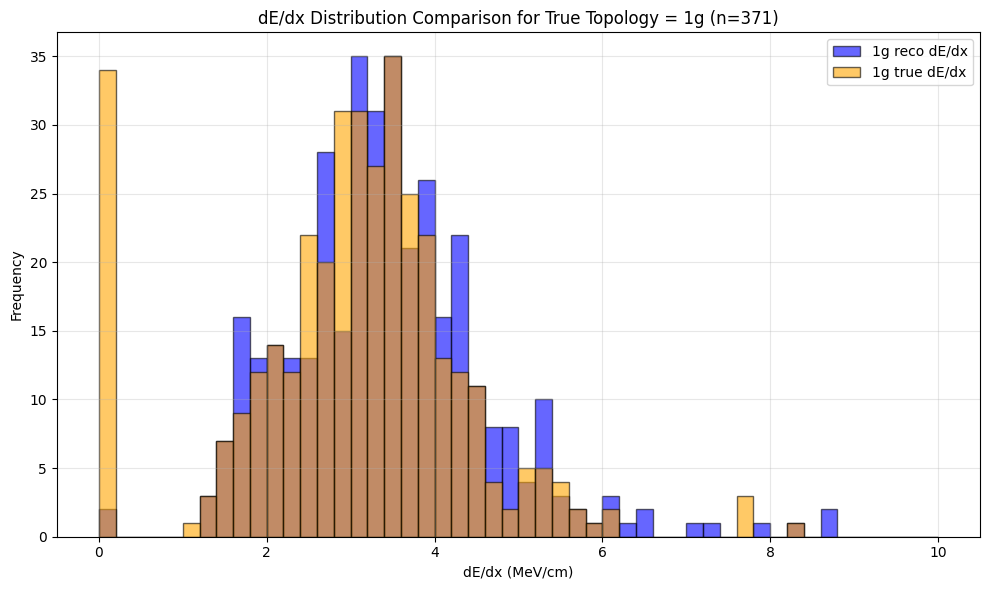

Total events with true_topology='1g': 371

Reco dE/dx statistics:
  Mean: 3.50
  Median: 3.39
  Std: 1.47

True dE/dx statistics:
  Mean: 3.05
  Median: 3.16
  Std: 1.58
start_dedx: 0.0
start_point: [-256.122    67.9787  635.054 ]
event: 2478003
reco_id: 25
true_id: 10
reco_vertex: [-256.122    67.9787  635.054 ]

start_dedx: 0.0
start_point: [-53.00998 -58.87329 479.186  ]
event: 2487005
reco_id: 7
true_id: 2
reco_vertex: [-51.46328 -81.38584 487.4721 ]

start_dedx: 0.0
start_point: [-322.71    -81.1933  787.202 ]
event: 2496010
reco_id: 49
true_id: 21
reco_vertex: [-322.896   -81.0073  787.202 ]

start_dedx: 0.0
start_point: [-345.03      76.90671  813.242  ]
event: 2509006
reco_id: 70
true_id: 35
reco_vertex: [-292.60303    83.453064  877.1223  ]

start_dedx: 0.0
start_point: [346.518   58.3067 627.614 ]
event: 2511007
reco_id: 49
true_id: 7
reco_vertex: [346.518   58.3067 627.614 ]

start_dedx: 0.0
start_point: [-255.006   -21.3013  535.73  ]
event: 2550001
reco_id: 22
true_id: 14


In [10]:
import matplotlib.pyplot as plt
import numpy as np

indices_1g = [i for i in range(len(true_topology)) if true_topology[i] == '1g' and i in indices_after_topo_cut]

reco_dedx_for_1g = [reco_dedx_list[i] for i in indices_1g]
true_dedx_for_1g = [true_dedx_list[i] for i in indices_1g]

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(reco_dedx_for_1g, bins=50, range=(0, 10), edgecolor='black', alpha=0.6, label='1g reco dE/dx', color='blue')
ax.hist(true_dedx_for_1g, bins=50, range=(0, 10), edgecolor='black', alpha=0.6, label='1g true dE/dx', color='orange')
ax.set_xlabel('dE/dx (MeV/cm)')
ax.set_ylabel('Frequency')
ax.set_title(f'dE/dx Distribution Comparison for True Topology = 1g (n={len(reco_dedx_for_1g)})')
#ax.set_xlim(0, 10)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total events with true_topology='1g': {len(indices_1g)}")
print(f"\nReco dE/dx statistics:")
print(f"  Mean: {np.mean(reco_dedx_for_1g):.2f}")
print(f"  Median: {np.median(reco_dedx_for_1g):.2f}")
print(f"  Std: {np.std(reco_dedx_for_1g):.2f}")
print(f"\nTrue dE/dx statistics:")
print(f"  Mean: {np.mean(true_dedx_for_1g):.2f}")
print(f"  Median: {np.median(true_dedx_for_1g):.2f}")
print(f"  Std: {np.std(true_dedx_for_1g):.2f}")

for i in indices_after_topo_cut:
    particle_list = reco_particle_info[i]
    
    # Count primary and valid particles
    num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
    
    # Issue warnings if not exactly 1 primary valid particle
    if num_primary_valid_particles == 0:
        print(f"Warning: Interaction {i} has 0 primary & valid particles")
        warning_zero_particles += 1
        continue
    elif num_primary_valid_particles > 1:
        print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
        warning_multiple_particles += 1
        continue
    
    # Find the primary and valid particle
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            dedx = particle_dict['start_dedx']

            # debug
            if dedx < 0.01:
                print(f"start_dedx: {dedx}")
                print(f"start_point: {particle_dict['start_point']}")
                print(f"event: {event_id[i]}")
                print(f"reco_id: {reco_id[i]}")
                print(f"true_id: {true_id[i]}")
                print(f"reco_vertex: {reco_vertex[i]}")
                print()

In [11]:
# Export dE/dx distribution data to CSV
import pandas as pd

# Export dE/dx data for 1g topology
dedx_data = pd.DataFrame({
    'dedx_reco': reco_dedx_for_1g,
})
dedx_data.to_csv(f'{data_dir}/full_spill_dedx_reco_1g.csv', index=False)

dedx_data_truth = pd.DataFrame({
    'dedx_truth': true_dedx_for_1g,
})
dedx_data_truth.to_csv(f'{data_dir}/full_spill_dedx_truth_1g.csv', index=False)

print(f"Exported dE/dx data to {data_dir}")
print(f"  - full_spill_dedx_reco_1g.csv: {len(reco_dedx_for_1g)} entries")
print(f"  - full_spill_dedx_truth_1g.csv: {len(true_dedx_for_1g)} entries")

Exported dE/dx data to ./data
  - full_spill_dedx_reco_1g.csv: 371 entries
  - full_spill_dedx_truth_1g.csv: 371 entries


## Cut

In [12]:
# Cut 4: dE/dx cut
import numpy as np

indices_after_dedx_cut = []

# Counters for warnings
warning_zero_particles = 0
warning_multiple_particles = 0
warning_dedx_out_of_range = 0

if ENABLE_DEDX_CUT:
    for i in indices_after_angle_cut:
        particle_list = reco_particle_info[i]
        
        # Count primary and valid particles
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        
        # Issue warnings if not exactly 1 primary valid particle
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_dedx_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_dedx_cut.append(i)
            continue
        
        # Find the primary and valid particle
        for particle_dict in particle_list:
            if particle_dict['primary'] and particle_dict['valid']:
                dedx = particle_dict['start_dedx']

                # debug
                if dedx < 0.01:
                    print(f"start_dedx: {dedx}")
                    print(f"event: {event_id[i]}")
                    print(f"reco_id: {reco_id[i]}")
                    print(f"true_id: {true_id[i]}")
                
                # Apply dE/dx cut
                if DEDX_CUT_MIN < dedx < DEDX_CUT_MAX:
                    indices_after_dedx_cut.append(i)
                else:
                    warning_dedx_out_of_range += 1
                break

    # Print summary
    print("\n" + "=" * 60)
    print("dE/dx Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_angle_cut)} interactions")
    print(f"Pass dE/dx cut: {len(indices_after_dedx_cut)} interactions")
    print(f"Pass rate: {len(indices_after_dedx_cut)/len(indices_after_angle_cut)*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_dedx_cut = indices_after_angle_cut.copy()
    print("\n" + "=" * 60)
    print("dE/dx Cut: DISABLED")
    print(f"All {len(indices_after_dedx_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_dedx_cut.copy()


dE/dx Cut: ENABLED
After last cut: 225 interactions
Pass dE/dx cut: 64 interactions
Pass rate: 28.44%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 5: Eθ²

## Distribution

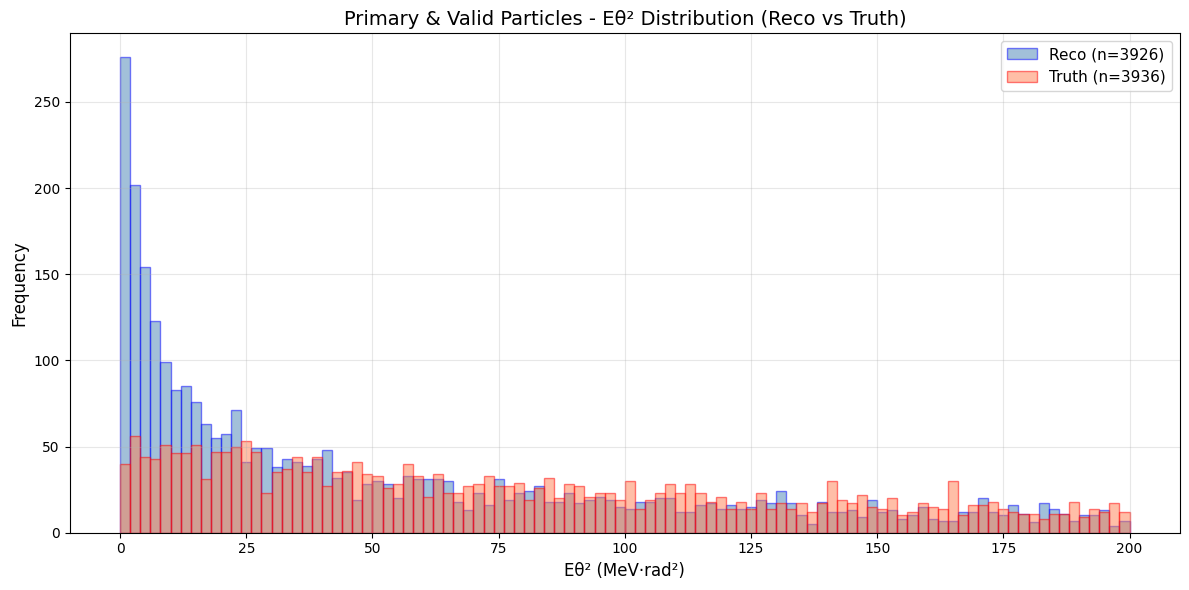

RECO:
  Total particles: 3926
  Mean: 189.70 MeV·rad²
  Median: 58.11 MeV·rad²
  Std: 905.03 MeV·rad²

TRUTH:
  Total particles: 3936
  Mean: 210.91 MeV·rad²
  Median: 123.04 MeV·rad²
  Std: 249.79 MeV·rad²


In [13]:
# Extract Eθ² for all primary and valid particles (reco and truth)
import matplotlib.pyplot as plt
import numpy as np

etheta2_list_reco = []  # Reco primary and valid particles
etheta2_list_truth = []  # Truth primary and valid particles

# Collect reco Eθ²
for i, particle_list in enumerate(reco_particle_info):
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            angle = particle_dict['angle_wrt_beam']
            angle_rad = angle * np.pi / 180.0
            etheta2 = ke * (angle_rad ** 2)
            etheta2_list_reco.append(etheta2)

# Collect truth Eθ²
for i, particle_list in enumerate(true_particle_info):
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            angle = particle_dict['angle_wrt_beam']
            angle_rad = angle * np.pi / 180.0
            etheta2 = ke * (angle_rad ** 2)
            etheta2_list_truth.append(etheta2)

# Create comparison plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(etheta2_list_reco, bins=100, range=(0, 200), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(etheta2_list_reco)})')
ax.hist(etheta2_list_truth, bins=100, range=(0, 200), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(etheta2_list_truth)})')

ax.set_xlabel('Eθ² (MeV·rad²)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Primary & Valid Particles - Eθ² Distribution (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 60)
print("RECO:")
print(f"  Total particles: {len(etheta2_list_reco)}")
print(f"  Mean: {np.mean(etheta2_list_reco):.2f} MeV·rad²")
print(f"  Median: {np.median(etheta2_list_reco):.2f} MeV·rad²")
print(f"  Std: {np.std(etheta2_list_reco):.2f} MeV·rad²")

print("\nTRUTH:")
print(f"  Total particles: {len(etheta2_list_truth)}")
print(f"  Mean: {np.mean(etheta2_list_truth):.2f} MeV·rad²")
print(f"  Median: {np.median(etheta2_list_truth):.2f} MeV·rad²")
print(f"  Std: {np.std(etheta2_list_truth):.2f} MeV·rad²")
print("=" * 60)

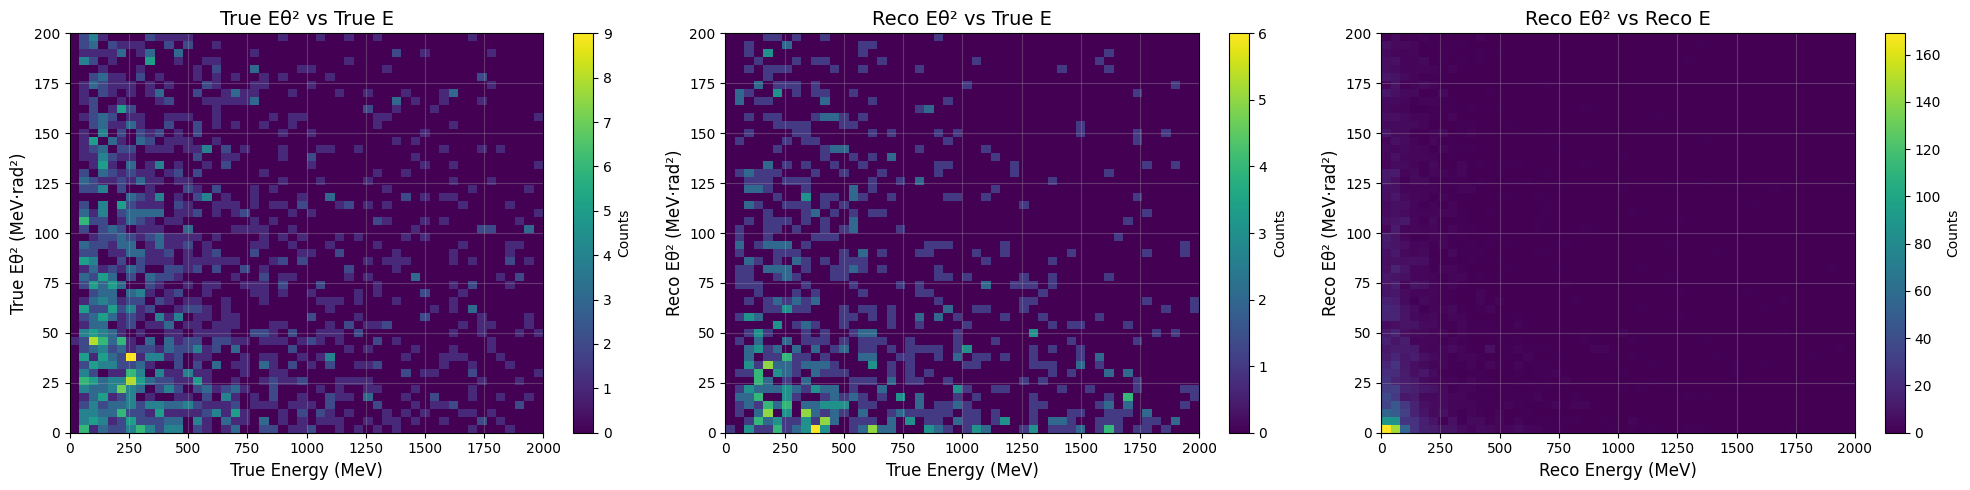

2D Histogram Statistics

Plot 1 - True Eθ² vs True E:
  Number of particles: 3936
  True E range: [37.60, 71399.58] MeV
  True Eθ² range: [0.14, 3089.23] MeV·rad²

Plot 2 - Reco Eθ² vs True E:
  Number of matched particles: 2068
  True E range: [37.60, 71399.58] MeV
  Reco Eθ² range: [0.00, 31143.83] MeV·rad²

Plot 3 - Reco Eθ² vs Reco E:
  Number of particles: 3926
  Reco E range: [25.02, 7307.05] MeV
  Reco Eθ² range: [0.00, 31143.83] MeV·rad²


In [14]:
# Plot 2D histograms: true Eθ² vs true E, reco Eθ² vs true E, reco Eθ² vs reco E
import matplotlib.pyplot as plt
import numpy as np

# Collect data for 2D histograms
true_ke_list = []
true_etheta2_list = []
reco_ke_list = []
reco_etheta2_list = []

# Iterate through matched pairs (reco and truth)
for i in indices_after_topo_cut:
    # Get truth particle info
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke_truth = particle_dict['reco_ke']
            angle_truth = particle_dict['angle_wrt_beam']
            angle_rad_truth = angle_truth * np.pi / 180.0
            etheta2_truth = ke_truth * (angle_rad_truth ** 2)
            
            true_ke_list.append(ke_truth)
            true_etheta2_list.append(etheta2_truth)
    
    # Get reco particle info
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke_reco = particle_dict['reco_ke']
            angle_reco = particle_dict['angle_wrt_beam']
            angle_rad_reco = angle_reco * np.pi / 180.0
            etheta2_reco = ke_reco * (angle_rad_reco ** 2)
            
            reco_ke_list.append(ke_reco)
            reco_etheta2_list.append(etheta2_reco)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: true Eθ² vs true E
h1 = axes[0].hist2d(true_ke_list, true_etheta2_list, bins=[50, 50], 
                     range=[[0, 2000], [0, 200]], cmap='viridis')
axes[0].set_xlabel('True Energy (MeV)', fontsize=12)
axes[0].set_ylabel('True Eθ² (MeV·rad²)', fontsize=12)
axes[0].set_title('True Eθ² vs True E', fontsize=14)
axes[0].grid(True, alpha=0.3)
plt.colorbar(h1[3], ax=axes[0], label='Counts')

# Plot 2: reco Eθ² vs true E
# Need to match reco and truth particles - using same indices
reco_etheta2_matched = []
true_ke_matched = []
for i in indices_after_topo_cut:
    # For simplicity, take the first primary valid particle from each
    truth_ke = None
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            truth_ke = particle_dict['reco_ke']
            break
    
    reco_etheta2 = None
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            angle = particle_dict['angle_wrt_beam']
            angle_rad = angle * np.pi / 180.0
            reco_etheta2 = ke * (angle_rad ** 2)
            break
    
    if truth_ke is not None and reco_etheta2 is not None:
        true_ke_matched.append(truth_ke)
        reco_etheta2_matched.append(reco_etheta2)

h2 = axes[1].hist2d(true_ke_matched, reco_etheta2_matched, bins=[50, 50], 
                     range=[[0, 2000], [0, 200]], cmap='viridis')
axes[1].set_xlabel('True Energy (MeV)', fontsize=12)
axes[1].set_ylabel('Reco Eθ² (MeV·rad²)', fontsize=12)
axes[1].set_title('Reco Eθ² vs True E', fontsize=14)
axes[1].grid(True, alpha=0.3)
plt.colorbar(h2[3], ax=axes[1], label='Counts')

# Plot 3: reco Eθ² vs reco E
h3 = axes[2].hist2d(reco_ke_list, reco_etheta2_list, bins=[50, 50], 
                     range=[[0, 2000], [0, 200]], cmap='viridis')
axes[2].set_xlabel('Reco Energy (MeV)', fontsize=12)
axes[2].set_ylabel('Reco Eθ² (MeV·rad²)', fontsize=12)
axes[2].set_title('Reco Eθ² vs Reco E', fontsize=14)
axes[2].grid(True, alpha=0.3)
plt.colorbar(h3[3], ax=axes[2], label='Counts')

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 80)
print("2D Histogram Statistics")
print("=" * 80)
print(f"\nPlot 1 - True Eθ² vs True E:")
print(f"  Number of particles: {len(true_ke_list)}")
print(f"  True E range: [{min(true_ke_list):.2f}, {max(true_ke_list):.2f}] MeV")
print(f"  True Eθ² range: [{min(true_etheta2_list):.2f}, {max(true_etheta2_list):.2f}] MeV·rad²")

print(f"\nPlot 2 - Reco Eθ² vs True E:")
print(f"  Number of matched particles: {len(true_ke_matched)}")
print(f"  True E range: [{min(true_ke_matched):.2f}, {max(true_ke_matched):.2f}] MeV")
print(f"  Reco Eθ² range: [{min(reco_etheta2_matched):.2f}, {max(reco_etheta2_matched):.2f}] MeV·rad²")

print(f"\nPlot 3 - Reco Eθ² vs Reco E:")
print(f"  Number of particles: {len(reco_ke_list)}")
print(f"  Reco E range: [{min(reco_ke_list):.2f}, {max(reco_ke_list):.2f}] MeV")
print(f"  Reco Eθ² range: [{min(reco_etheta2_list):.2f}, {max(reco_etheta2_list):.2f}] MeV·rad²")
print("=" * 80)

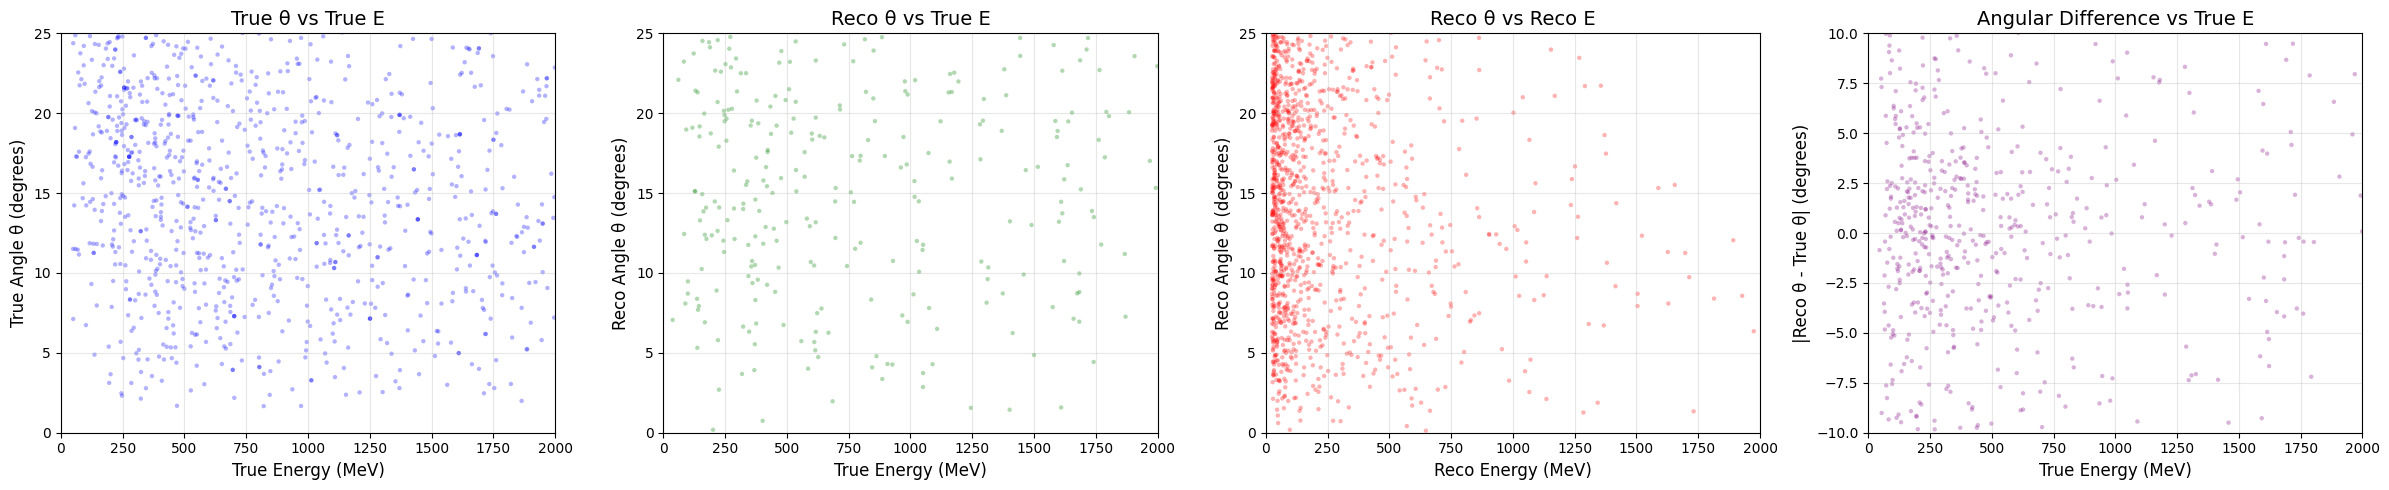

Theta-E Scatter Plot Statistics

Plot 1 - True θ vs True E:
  Number of particles: 3936
  True E range: [37.60, 71399.58] MeV
  True θ range: [0.21, 176.56]°

Plot 2 - Reco θ vs True E:
  Number of matched particles: 2068
  True E range: [37.60, 71399.58] MeV
  Reco θ range: [0.13, 176.88]°

Plot 3 - Reco θ vs Reco E:
  Number of particles: 3926
  Reco E range: [25.02, 7307.05] MeV
  Reco θ range: [0.13, 176.88]°

Plot 4 - |Reco θ - True θ| vs True E:
  Number of matched particles: 2068
  True E range: [37.60, 71399.58] MeV
  |Δθ| range: [-158.91, 173.72]°
  Mean |Δθ|: 22.73°
  Median |Δθ|: 8.48°
  Std |Δθ|: 44.13°


In [15]:
# Plot theta vs E scatter plots: true theta vs true E, reco theta vs true E, reco theta vs reco E
# Plus: |Reco theta - True theta| vs E scatter plot
import matplotlib.pyplot as plt
import numpy as np

# Set x and y axis ranges for theta-E plots
THETA_X_RANGE = [0, 2000]  # Energy range (MeV)
THETA_Y_RANGE = [0, 25]    # Angle range (degrees)
DELTA_THETA_Y_RANGE = [-10, 10]  # Angle difference range (degrees)

# Collect data for theta-E scatter plots
true_ke_for_theta = []
true_theta_list = []
reco_ke_for_theta = []
reco_theta_list = []

# Iterate through matched pairs (reco and truth)
for i in indices_after_topo_cut:
    # Get truth particle info
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke_truth = particle_dict['reco_ke']
            angle_truth = particle_dict['angle_wrt_beam']
            
            true_ke_for_theta.append(ke_truth)
            true_theta_list.append(angle_truth)
    
    # Get reco particle info
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke_reco = particle_dict['reco_ke']
            angle_reco = particle_dict['angle_wrt_beam']
            
            reco_ke_for_theta.append(ke_reco)
            reco_theta_list.append(angle_reco)

# Match reco and truth particles for the middle plot
reco_theta_matched = []
true_ke_for_theta_matched = []
for i in indices_after_topo_cut:
    # Take the first primary valid particle from each
    truth_ke = None
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            truth_ke = particle_dict['reco_ke']
            break
    
    reco_theta = None
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            reco_theta = particle_dict['angle_wrt_beam']
            break
    
    if truth_ke is not None and reco_theta is not None:
        true_ke_for_theta_matched.append(truth_ke)
        reco_theta_matched.append(reco_theta)

# Collect data for |Reco theta - True theta| vs E
delta_theta_list = []
energy_for_delta_theta = []

for i in indices_after_topo_cut:
    # Get first primary valid particle from truth
    true_theta = None
    true_ke = None
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            true_theta = particle_dict['angle_wrt_beam']
            true_ke = particle_dict['reco_ke']
            break
    
    # Get first primary valid particle from reco
    reco_theta = None
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            reco_theta = particle_dict['angle_wrt_beam']
            break
    
    # Calculate |Reco theta - True theta|
    if true_theta is not None and reco_theta is not None and true_ke is not None:
        delta_theta = (reco_theta - true_theta)
        delta_theta_list.append(delta_theta)
        energy_for_delta_theta.append(true_ke)

# Create figure with 4 subplots for theta-E scatter plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Scatter Plot 1: true theta vs true E
axes[0].scatter(true_ke_for_theta, true_theta_list, alpha=0.3, s=10, c='blue', edgecolors='none')
axes[0].set_xlabel('True Energy (MeV)', fontsize=12)
axes[0].set_ylabel('True Angle θ (degrees)', fontsize=12)
axes[0].set_title('True θ vs True E', fontsize=14)
axes[0].set_xlim(THETA_X_RANGE)
axes[0].set_ylim(THETA_Y_RANGE)
axes[0].grid(True, alpha=0.3)

# Scatter Plot 2: reco theta vs true E
axes[1].scatter(true_ke_for_theta_matched, reco_theta_matched, alpha=0.3, s=10, c='green', edgecolors='none')
axes[1].set_xlabel('True Energy (MeV)', fontsize=12)
axes[1].set_ylabel('Reco Angle θ (degrees)', fontsize=12)
axes[1].set_title('Reco θ vs True E', fontsize=14)
axes[1].set_xlim(THETA_X_RANGE)
axes[1].set_ylim(THETA_Y_RANGE)
axes[1].grid(True, alpha=0.3)

# Scatter Plot 3: reco theta vs reco E
axes[2].scatter(reco_ke_for_theta, reco_theta_list, alpha=0.3, s=10, c='red', edgecolors='none')
axes[2].set_xlabel('Reco Energy (MeV)', fontsize=12)
axes[2].set_ylabel('Reco Angle θ (degrees)', fontsize=12)
axes[2].set_title('Reco θ vs Reco E', fontsize=14)
axes[2].set_xlim(THETA_X_RANGE)
axes[2].set_ylim(THETA_Y_RANGE)
axes[2].grid(True, alpha=0.3)

# Scatter Plot 4: |Reco theta - True theta| vs E
axes[3].scatter(energy_for_delta_theta, delta_theta_list, alpha=0.3, s=10, c='purple', edgecolors='none')
axes[3].set_xlabel('True Energy (MeV)', fontsize=12)
axes[3].set_ylabel('|Reco θ - True θ| (degrees)', fontsize=12)
axes[3].set_title('Angular Difference vs True E', fontsize=14)
axes[3].set_xlim(THETA_X_RANGE)
axes[3].set_ylim(DELTA_THETA_Y_RANGE)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 80)
print("Theta-E Scatter Plot Statistics")
print("=" * 80)
print(f"\nPlot 1 - True θ vs True E:")
print(f"  Number of particles: {len(true_ke_for_theta)}")
print(f"  True E range: [{min(true_ke_for_theta):.2f}, {max(true_ke_for_theta):.2f}] MeV")
print(f"  True θ range: [{min(true_theta_list):.2f}, {max(true_theta_list):.2f}]°")

print(f"\nPlot 2 - Reco θ vs True E:")
print(f"  Number of matched particles: {len(true_ke_for_theta_matched)}")
print(f"  True E range: [{min(true_ke_for_theta_matched):.2f}, {max(true_ke_for_theta_matched):.2f}] MeV")
print(f"  Reco θ range: [{min(reco_theta_matched):.2f}, {max(reco_theta_matched):.2f}]°")

print(f"\nPlot 3 - Reco θ vs Reco E:")
print(f"  Number of particles: {len(reco_ke_for_theta)}")
print(f"  Reco E range: [{min(reco_ke_for_theta):.2f}, {max(reco_ke_for_theta):.2f}] MeV")
print(f"  Reco θ range: [{min(reco_theta_list):.2f}, {max(reco_theta_list):.2f}]°")

print(f"\nPlot 4 - |Reco θ - True θ| vs True E:")
print(f"  Number of matched particles: {len(delta_theta_list)}")
print(f"  True E range: [{min(energy_for_delta_theta):.2f}, {max(energy_for_delta_theta):.2f}] MeV")
print(f"  |Δθ| range: [{min(delta_theta_list):.2f}, {max(delta_theta_list):.2f}]°")
print(f"  Mean |Δθ|: {np.mean(delta_theta_list):.2f}°")
print(f"  Median |Δθ|: {np.median(delta_theta_list):.2f}°")
print(f"  Std |Δθ|: {np.std(delta_theta_list):.2f}°")
print("=" * 80)

In [16]:
# Export Eθ² distribution data to CSV
import pandas as pd

# Export Eθ² data
etheta2_data = pd.DataFrame({
    'etheta2_reco': etheta2_list_reco,
})
etheta2_data.to_csv(f'{data_dir}/full_spill_etheta2_reco.csv', index=False)

etheta2_data_truth = pd.DataFrame({
    'etheta2_truth': etheta2_list_truth,
})
etheta2_data_truth.to_csv(f'{data_dir}/full_spill_etheta2_truth.csv', index=False)

print(f"Exported Eθ² data to {data_dir}")
print(f"  - full_spill_etheta2_reco.csv: {len(etheta2_list_reco)} entries")
print(f"  - full_spill_etheta2_truth.csv: {len(etheta2_list_truth)} entries")

Exported Eθ² data to ./data
  - full_spill_etheta2_reco.csv: 3926 entries
  - full_spill_etheta2_truth.csv: 3936 entries


## Cut

In [17]:
# Cut 5: Eθ² cut
import numpy as np

indices_after_etheta2_cut = []

# Counters for warnings
warning_zero_particles = 0
warning_multiple_particles = 0
warning_etheta2_out_of_range = 0

if ENABLE_ETHETA2_CUT:
    for i in indices_after_dedx_cut:
        particle_list = reco_particle_info[i]
        
        # Count primary and valid particles
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        
        # Issue warnings if not exactly 1 primary valid particle
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_etheta2_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_etheta2_cut.append(i)
            continue
        
        # Find the primary and valid particle
        for particle_dict in particle_list:
            if particle_dict['primary'] and particle_dict['valid']:
                ke = particle_dict['reco_ke']  # MeV
                angle = particle_dict['angle_wrt_beam']  # degrees
                angle_rad = angle * np.pi / 180.0  # convert to radians
                etheta2 = ke * (angle_rad ** 2)  # MeV·rad²
                
                # Apply Eθ² cut
                if etheta2 < ETHETA2_CUT_MAX:
                    indices_after_etheta2_cut.append(i)
                else:
                    warning_etheta2_out_of_range += 1
                break

    # Print summary
    print("\n" + "=" * 60)
    print("Eθ² Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_dedx_cut)} interactions")
    print(f"Pass Eθ² cut: {len(indices_after_etheta2_cut)} interactions")
    print(f"Pass rate: {len(indices_after_etheta2_cut)/len(indices_after_dedx_cut)*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_etheta2_cut = indices_after_dedx_cut.copy()
    print("\n" + "=" * 60)
    print("Eθ² Cut: DISABLED")
    print(f"All {len(indices_after_etheta2_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_etheta2_cut.copy()


Eθ² Cut: ENABLED
After last cut: 64 interactions
Pass Eθ² cut: 49 interactions
Pass rate: 76.56%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 6: Kinetic Energy

## Distribution

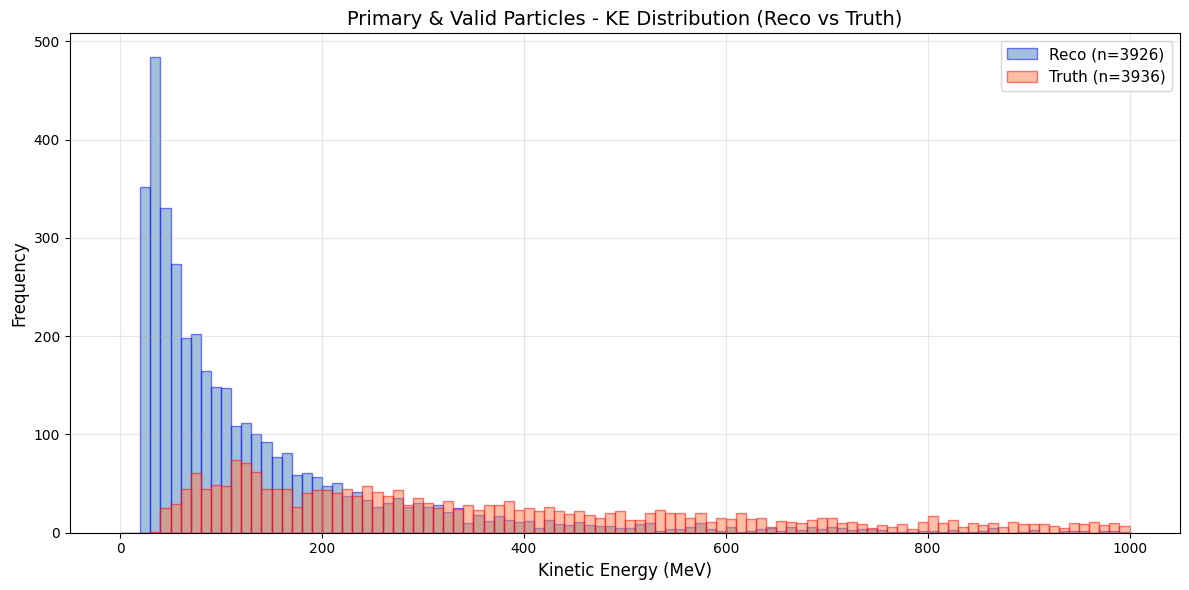

RECO:
  Total particles: 3926
  Mean: 189.08 MeV
  Median: 87.08 MeV
  Std: 399.09 MeV

TRUTH:
  Total particles: 3936
  Mean: 3727.45 MeV
  Median: 729.96 MeV
  Std: 7479.92 MeV


In [18]:
# Extract KE for all primary and valid particles (reco and truth)
import matplotlib.pyplot as plt
import numpy as np

ke_list_reco = []  # Reco primary and valid particles
ke_list_truth = []  # Truth primary and valid particles

# Collect reco KE
for i, particle_list in enumerate(reco_particle_info):
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            ke_list_reco.append(ke)

# Collect truth KE
for i, particle_list in enumerate(true_particle_info):
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in particle_list:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            ke_list_truth.append(ke)

# Create comparison plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(ke_list_reco, bins=100, range=(0, 1000), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(ke_list_reco)})')
ax.hist(ke_list_truth, bins=100, range=(0, 1000), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(ke_list_truth)})')

ax.set_xlabel('Kinetic Energy (MeV)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Primary & Valid Particles - KE Distribution (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 60)
print("RECO:")
print(f"  Total particles: {len(ke_list_reco)}")
print(f"  Mean: {np.mean(ke_list_reco):.2f} MeV")
print(f"  Median: {np.median(ke_list_reco):.2f} MeV")
print(f"  Std: {np.std(ke_list_reco):.2f} MeV")

print("\nTRUTH:")
print(f"  Total particles: {len(ke_list_truth)}")
print(f"  Mean: {np.mean(ke_list_truth):.2f} MeV")
print(f"  Median: {np.median(ke_list_truth):.2f} MeV")
print(f"  Std: {np.std(ke_list_truth):.2f} MeV")
print("=" * 60)

In [19]:
# Export KE distribution data to CSV
import pandas as pd

# Export KE data
ke_data = pd.DataFrame({
    'ke_reco': ke_list_reco,
})
ke_data.to_csv(f'{data_dir}/full_spill_ke_reco.csv', index=False)

ke_data_truth = pd.DataFrame({
    'ke_truth': ke_list_truth,
})
ke_data_truth.to_csv(f'{data_dir}/full_spill_ke_truth.csv', index=False)

print(f"Exported KE data to {data_dir}")
print(f"  - full_spill_ke_reco.csv: {len(ke_list_reco)} entries")
print(f"  - full_spill_ke_truth.csv: {len(ke_list_truth)} entries")

Exported KE data to ./data
  - full_spill_ke_reco.csv: 3926 entries
  - full_spill_ke_truth.csv: 3936 entries


## Cut

In [20]:
# Cut 6: KE cut
import numpy as np

indices_after_ke_cut = []

# Counters for warnings
warning_zero_particles = 0
warning_multiple_particles = 0

if ENABLE_KE_CUT:
    for i in indices_after_etheta2_cut:
        particle_list = reco_particle_info[i]
        
        # Count primary and valid particles
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        
        # Issue warnings if not exactly 1 primary valid particle
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_ke_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_ke_cut.append(i)
            continue
        
        # Find the primary and valid particle
        for particle_dict in particle_list:
            if particle_dict['primary'] and particle_dict['valid']:
                ke = particle_dict['reco_ke']  # MeV
                
                # Apply KE cut
                if ke > KE_CUT_MIN:
                    indices_after_ke_cut.append(i)
                break

    # Print summary
    print("\n" + "=" * 60)
    print("KE Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_etheta2_cut)} interactions")
    print(f"Pass KE cut: {len(indices_after_ke_cut)} interactions")
    print(f"Pass rate: {len(indices_after_ke_cut)/len(indices_after_etheta2_cut)*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_ke_cut = indices_after_etheta2_cut.copy()
    print("\n" + "=" * 60)
    print("KE Cut: DISABLED")
    print(f"All {len(indices_after_ke_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_ke_cut.copy()


KE Cut: ENABLED
After last cut: 49 interactions
Pass KE cut: 17 interactions
Pass rate: 34.69%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 7: PCA Analysis

## Distribution

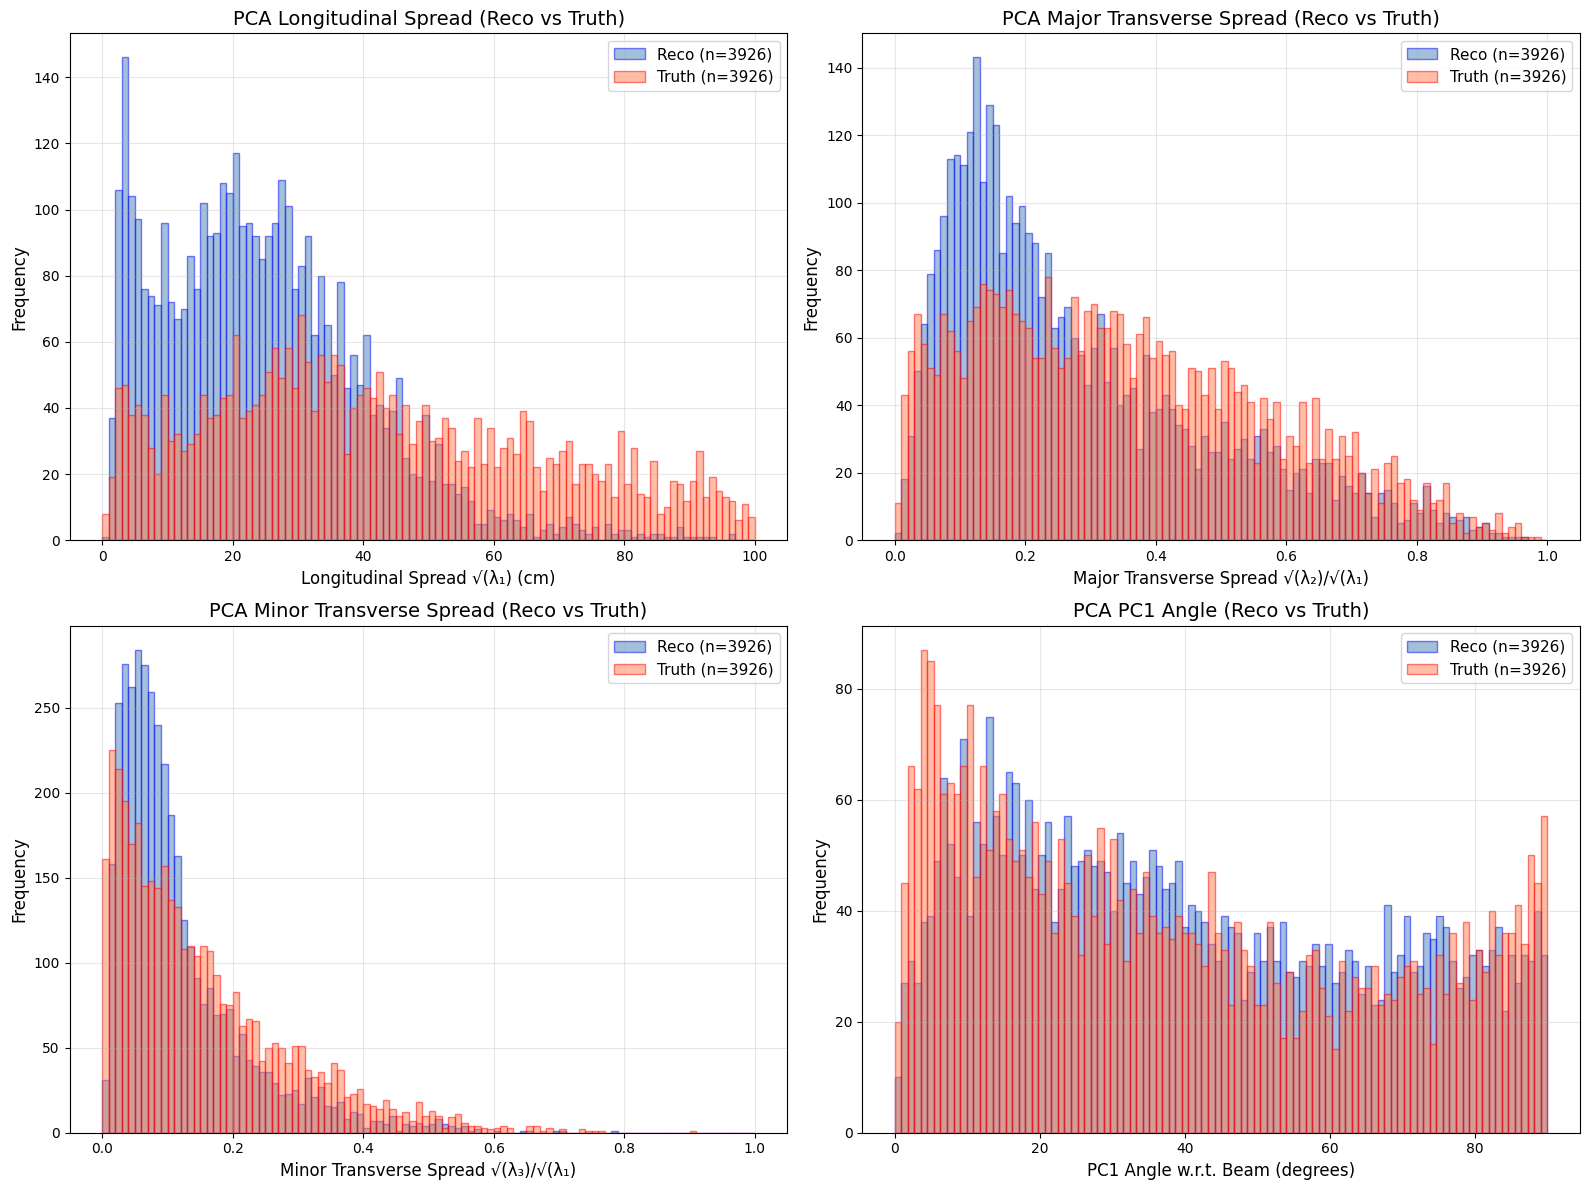

RECO PCA Statistics:
Longitudinal √(λ₁) (cm):
  Mean: 24.89, Median: 22.71, Std: 16.82

Major Transverse √(λ₂)/√(λ₁):
  Mean: 0.285, Median: 0.223, Std: 0.204

Minor Transverse √(λ₃)/√(λ₁):
  Mean: 0.118, Median: 0.087, Std: 0.100

PC1 Angle (degrees):
  Mean: 40.59, Median: 36.66, Std: 25.41

TRUTH PCA Statistics:
Longitudinal √(λ₁) (cm):
  Mean: 60.79, Median: 47.35, Std: 45.81

Major Transverse √(λ₂)/√(λ₁):
  Mean: 0.351, Median: 0.323, Std: 0.220

Minor Transverse √(λ₃)/√(λ₁):
  Mean: 0.154, Median: 0.116, Std: 0.133

PC1 Angle (degrees):
  Mean: 38.62, Median: 33.61, Std: 27.25


In [21]:
# Extract PCA features for all interactions (reco and truth)
import matplotlib.pyplot as plt
import numpy as np

# Lists for PCA features (reco)
longitudinal_reco = []  # sqrt(λ1)
transverse_major_reco = []  # sqrt(λ2)/sqrt(λ1)
transverse_minor_reco = []  # sqrt(λ3)/sqrt(λ1)
pc1_angle_reco = []  # angle between PC1 and beam direction

# Lists for PCA features (truth)
longitudinal_truth = []
transverse_major_truth = []
transverse_minor_truth = []
pc1_angle_truth = []

# Collect reco PCA features
for i, pca_vars in enumerate(reco_pca_variables):
    if i not in indices_after_topo_cut:
        continue
    eigenvalues = pca_vars['eigenvalues']
    angle = pca_vars['angle_wrt_beam']
    
    # Skip invalid PCA results
    if eigenvalues[0] < 0:
        continue
    
    # Calculate longitudinal spread: sqrt(λ1)
    long_spread = np.sqrt(eigenvalues[0])
    longitudinal_reco.append(long_spread)
    
    # Calculate transverse spreads (ratios)
    if eigenvalues[0] > 0:
        trans_major = np.sqrt(eigenvalues[1]) / np.sqrt(eigenvalues[0])
        trans_minor = np.sqrt(eigenvalues[2]) / np.sqrt(eigenvalues[0])
        transverse_major_reco.append(trans_major)
        transverse_minor_reco.append(trans_minor)
    
    # Store PC1 angle
    pc1_angle_reco.append(angle)

# Collect truth PCA features
for i, pca_vars in enumerate(true_pca_variables):
    if i not in indices_after_topo_cut:
        continue
    if pca_vars == '':
        continue
    
    eigenvalues = pca_vars['eigenvalues']
    angle = pca_vars['angle_wrt_beam']
    
    # Skip invalid PCA results
    if eigenvalues[0] < 0:
        continue
    
    # Calculate longitudinal spread: sqrt(λ1)
    long_spread = np.sqrt(eigenvalues[0])
    longitudinal_truth.append(long_spread)
    
    # Calculate transverse spreads (ratios)
    if eigenvalues[0] > 0:
        trans_major = np.sqrt(eigenvalues[1]) / np.sqrt(eigenvalues[0])
        trans_minor = np.sqrt(eigenvalues[2]) / np.sqrt(eigenvalues[0])
        transverse_major_truth.append(trans_major)
        transverse_minor_truth.append(trans_minor)
    
    # Store PC1 angle
    pc1_angle_truth.append(angle)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Longitudinal spread (sqrt(λ1))
ax = axes[0, 0]
ax.hist(longitudinal_reco, bins=100, range=(0, 100), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(longitudinal_reco)})')
ax.hist(longitudinal_truth, bins=100, range=(0, 100), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(longitudinal_truth)})')
ax.set_xlabel('Longitudinal Spread √(λ₁) (cm)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA Longitudinal Spread (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Major transverse spread (sqrt(λ2)/sqrt(λ1))
ax = axes[0, 1]
ax.hist(transverse_major_reco, bins=100, range=(0, 1), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(transverse_major_reco)})')
ax.hist(transverse_major_truth, bins=100, range=(0, 1), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(transverse_major_truth)})')
ax.set_xlabel('Major Transverse Spread √(λ₂)/√(λ₁)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA Major Transverse Spread (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Minor transverse spread (sqrt(λ3)/sqrt(λ1))
ax = axes[1, 0]
ax.hist(transverse_minor_reco, bins=100, range=(0, 1), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(transverse_minor_reco)})')
ax.hist(transverse_minor_truth, bins=100, range=(0, 1), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(transverse_minor_truth)})')
ax.set_xlabel('Minor Transverse Spread √(λ₃)/√(λ₁)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA Minor Transverse Spread (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: PC1 angle with beam
ax = axes[1, 1]
ax.hist(pc1_angle_reco, bins=100, range=(0, 90), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(pc1_angle_reco)})')
ax.hist(pc1_angle_truth, bins=100, range=(0, 90), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(pc1_angle_truth)})')
ax.set_xlabel('PC1 Angle w.r.t. Beam (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA PC1 Angle (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 60)
print("RECO PCA Statistics:")
print("=" * 60)
print(f"Longitudinal √(λ₁) (cm):")
print(f"  Mean: {np.mean(longitudinal_reco):.2f}, Median: {np.median(longitudinal_reco):.2f}, Std: {np.std(longitudinal_reco):.2f}")
print(f"\nMajor Transverse √(λ₂)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_major_reco):.3f}, Median: {np.median(transverse_major_reco):.3f}, Std: {np.std(transverse_major_reco):.3f}")
print(f"\nMinor Transverse √(λ₃)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_minor_reco):.3f}, Median: {np.median(transverse_minor_reco):.3f}, Std: {np.std(transverse_minor_reco):.3f}")
print(f"\nPC1 Angle (degrees):")
print(f"  Mean: {np.mean(pc1_angle_reco):.2f}, Median: {np.median(pc1_angle_reco):.2f}, Std: {np.std(pc1_angle_reco):.2f}")

print("\n" + "=" * 60)
print("TRUTH PCA Statistics:")
print("=" * 60)
print(f"Longitudinal √(λ₁) (cm):")
print(f"  Mean: {np.mean(longitudinal_truth):.2f}, Median: {np.median(longitudinal_truth):.2f}, Std: {np.std(longitudinal_truth):.2f}")
print(f"\nMajor Transverse √(λ₂)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_major_truth):.3f}, Median: {np.median(transverse_major_truth):.3f}, Std: {np.std(transverse_major_truth):.3f}")
print(f"\nMinor Transverse √(λ₃)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_minor_truth):.3f}, Median: {np.median(transverse_minor_truth):.3f}, Std: {np.std(transverse_minor_truth):.3f}")
print(f"\nPC1 Angle (degrees):")
print(f"  Mean: {np.mean(pc1_angle_truth):.2f}, Median: {np.median(pc1_angle_truth):.2f}, Std: {np.std(pc1_angle_truth):.2f}")
print("=" * 60)

In [22]:
# DEBUG: Check PCA data list lengths
print("=" * 60)
print("DEBUG: PCA Data List Lengths")
print("=" * 60)
print(f"\nReco lists:")
print(f"  longitudinal_reco: {len(longitudinal_reco)}")
print(f"  transverse_major_reco: {len(transverse_major_reco)}")
print(f"  transverse_minor_reco: {len(transverse_minor_reco)}")
print(f"  pc1_angle_reco: {len(pc1_angle_reco)}")

print(f"\nTruth lists:")
print(f"  longitudinal_truth: {len(longitudinal_truth)}")
print(f"  transverse_major_truth: {len(transverse_major_truth)}")
print(f"  transverse_minor_truth: {len(transverse_minor_truth)}")
print(f"  pc1_angle_truth: {len(pc1_angle_truth)}")

print("\n" + "=" * 60)
print("Issue: Lists must have the same length to create DataFrame")
print("=" * 60)

DEBUG: PCA Data List Lengths

Reco lists:
  longitudinal_reco: 3926
  transverse_major_reco: 3926
  transverse_minor_reco: 3926
  pc1_angle_reco: 3926

Truth lists:
  longitudinal_truth: 3926
  transverse_major_truth: 3926
  transverse_minor_truth: 3926
  pc1_angle_truth: 3926

Issue: Lists must have the same length to create DataFrame


In [23]:
# Export PCA distribution data to CSV
import pandas as pd

# For reco: only use entries where all lists have values (skip inconsistent points)
min_len_reco = min(len(longitudinal_reco), len(transverse_major_reco), 
                   len(transverse_minor_reco), len(pc1_angle_reco))
print(f"Reco: Found {len(longitudinal_reco) - min_len_reco} inconsistent points, skipping them")

# Export PCA data - reco (only consistent entries)
pca_data_reco = pd.DataFrame({
    'longitudinal_reco': longitudinal_reco[:min_len_reco],
    'transverse_major_reco': transverse_major_reco[:min_len_reco],
    'transverse_minor_reco': transverse_minor_reco[:min_len_reco],
    'pc1_angle_reco': pc1_angle_reco[:min_len_reco],
})
pca_data_reco.to_csv(f'{data_dir}/full_spill_pca_reco.csv', index=False)

# For truth: only use entries where all lists have values (skip inconsistent points)
min_len_truth = min(len(longitudinal_truth), len(transverse_major_truth), 
                    len(transverse_minor_truth), len(pc1_angle_truth))
print(f"Truth: Found {len(longitudinal_truth) - min_len_truth} inconsistent points, skipping them")

pca_data_truth = pd.DataFrame({
    'longitudinal_truth': longitudinal_truth[:min_len_truth],
    'transverse_major_truth': transverse_major_truth[:min_len_truth],
    'transverse_minor_truth': transverse_minor_truth[:min_len_truth],
    'pc1_angle_truth': pc1_angle_truth[:min_len_truth],
})
pca_data_truth.to_csv(f'{data_dir}/full_spill_pca_truth.csv', index=False)

print(f"\nExported PCA data to {data_dir}")
print(f"  - full_spill_pca_reco.csv: {len(pca_data_reco)} entries")
print(f"  - full_spill_pca_truth.csv: {len(pca_data_truth)} entries")

Reco: Found 0 inconsistent points, skipping them
Truth: Found 0 inconsistent points, skipping them



Exported PCA data to ./data
  - full_spill_pca_reco.csv: 3926 entries
  - full_spill_pca_truth.csv: 3926 entries


## Cut

In [24]:
# Cut 7: PCA cuts
import numpy as np

indices_after_pca_cut = []

# Counters for warnings and failures
fail_longitudinal = 0
fail_transverse_major = 0
fail_transverse_minor = 0
fail_pc1_angle = 0

if ENABLE_PCA_CUT:
    for i in indices_after_ke_cut:
        # Get PCA variables for this interaction
        pca_vars = reco_pca_variables[i]
        
        # Check if pca_vars is a dictionary (new format)
        if isinstance(pca_vars, dict):
            eigenvalues = pca_vars['eigenvalues']
            pc1_angle = pca_vars['angle_wrt_beam']
        else:
            # Old format: tuple (eigenvalues, eigenvectors, centroid)
            eigenvalues, eigenvectors, centroid = pca_vars
            # Calculate angle manually
            th = -0.101  # radians
            beam_direction = np.array([0, np.sin(th), np.cos(th)])
            pc1 = eigenvectors[:, 0]
            cos_angle = np.abs(np.dot(pc1, beam_direction))
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            pc1_angle = np.arccos(cos_angle) * 180.0 / np.pi
        
        
        # Calculate PCA features
        # 1. Longitudinal spread: sqrt(λ1)
        longitudinal_spread = np.sqrt(eigenvalues[0])
        
        # 2. Major transverse spread: sqrt(λ2)/sqrt(λ1)
        transverse_major_spread = np.sqrt(eigenvalues[1]) / np.sqrt(eigenvalues[0])
        
        # 3. Minor transverse spread: sqrt(λ3)/sqrt(λ1)
        transverse_minor_spread = np.sqrt(eigenvalues[2]) / np.sqrt(eigenvalues[0])
        
        # Apply PCA cuts
        pass_all_cuts = True
        
        # Cut 1: Longitudinal spread
        if not (PCA_LONGITUDINAL_MIN < longitudinal_spread < PCA_LONGITUDINAL_MAX):
            fail_longitudinal += 1
            pass_all_cuts = False
        
        # Cut 2: Major transverse spread
        if not (PCA_TRANSVERSE_MAJOR_MIN < transverse_major_spread < PCA_TRANSVERSE_MAJOR_MAX):
            fail_transverse_major += 1
            pass_all_cuts = False
        
        # Cut 3: Minor transverse spread
        if not (PCA_TRANSVERSE_MINOR_MIN < transverse_minor_spread < PCA_TRANSVERSE_MINOR_MAX):
            fail_transverse_minor += 1
            pass_all_cuts = False
        
        # Cut 4: PC1 angle (only if enabled, i.e., < 90 degrees)
        if PCA_PC1_ANGLE_MAX < 90 and pc1_angle > PCA_PC1_ANGLE_MAX:
            fail_pc1_angle += 1
            pass_all_cuts = False
        
        if pass_all_cuts:
            indices_after_pca_cut.append(i)

    # Print summary
    print("\n" + "=" * 60)
    print("PCA Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_ke_cut)} interactions")
    print(f"Pass PCA cuts: {len(indices_after_pca_cut)} interactions")
    print(f"Pass rate: {len(indices_after_pca_cut)/len(indices_after_ke_cut)*100:.2f}%")
    print(f"\nCut Failures:")
    print(f"  Longitudinal spread out of range: {fail_longitudinal}")
    print(f"  Major transverse spread out of range: {fail_transverse_major}")
    print(f"  Minor transverse spread out of range: {fail_transverse_minor}")
    print(f"  PC1 angle out of range: {fail_pc1_angle}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_pca_cut = indices_after_ke_cut.copy()
    print("\n" + "=" * 60)
    print("PCA Cut: DISABLED")
    print(f"All {len(indices_after_pca_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_pca_cut.copy()


PCA Cut: ENABLED
After last cut: 17 interactions
Pass PCA cuts: 17 interactions
Pass rate: 100.00%

Cut Failures:
  Longitudinal spread out of range: 0
  Major transverse spread out of range: 0
  Minor transverse spread out of range: 0
  PC1 angle out of range: 0


# Cut 8: Point Cloud Proximity Cut

In [25]:
# Cut 8: Point Cloud Proximity Cut
# Exclude interactions that have close proximity to other interactions in the same event
import importlib

if ENABLE_PROXIMITY_CUT:
    # 删除缓存
    if 'data_process_modules' in sys.modules:
        del sys.modules['data_process_modules']
    from data_process_modules import check_proximity_contact

    # Check proximity
    # Note: file number is extracted directly from event_id (first 4 digits)
    indices_after_proximity_cut, proximity_results = check_proximity_contact(
        indices_to_check=indices_after_pca_cut,
        event_ids=event_id,
        reco_ids=reco_id,
        distance_threshold=PROXIMITY_DISTANCE_THRESHOLD
    )
    
    print("\n" + "=" * 60)
    print("Proximity Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_pca_cut)} interactions")
    print(f"Pass Proximity cut: {len(indices_after_proximity_cut)} interactions")
    print(f"Pass rate: {len(indices_after_proximity_cut)/len(indices_after_pca_cut)*100:.2f}%")
    print("=" * 60)
    print(proximity_results)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_proximity_cut = indices_after_pca_cut.copy()
    proximity_results = {}
    print("\n" + "=" * 60)
    print("Proximity Cut: DISABLED")
    print(f"All {len(indices_after_proximity_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_backgrounds = indices_after_proximity_cut.copy()

print(event_id[65195])

Cut: Point Cloud Proximity Check
Excluding interactions with point cloud distance < 0.5 cm
to any other interaction in the same event

Processing 17 interactions...


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome054 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765396679}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.0002465.LARCV_spine.h5,
    name: hdf5}
build: {mode: both, fragments: false, particles: true, interactions: true, units: cm}

Will load 1 

# Analysis of remaining background

REMAINING BACKGROUND ANALYSIS
Total remaining interactions: 9
True NUEEL signals in remaining: 1

1. TRUE TOPOLOGY DISTRIBUTION

Topology counts:
  1mu: 4 (44.4%)
  2g1mu: 1 (11.1%)
  1pi: 1 (11.1%)
  1e: 1 (11.1%)
  NaN: 1 (11.1%)
  1g1mu: 1 (11.1%)


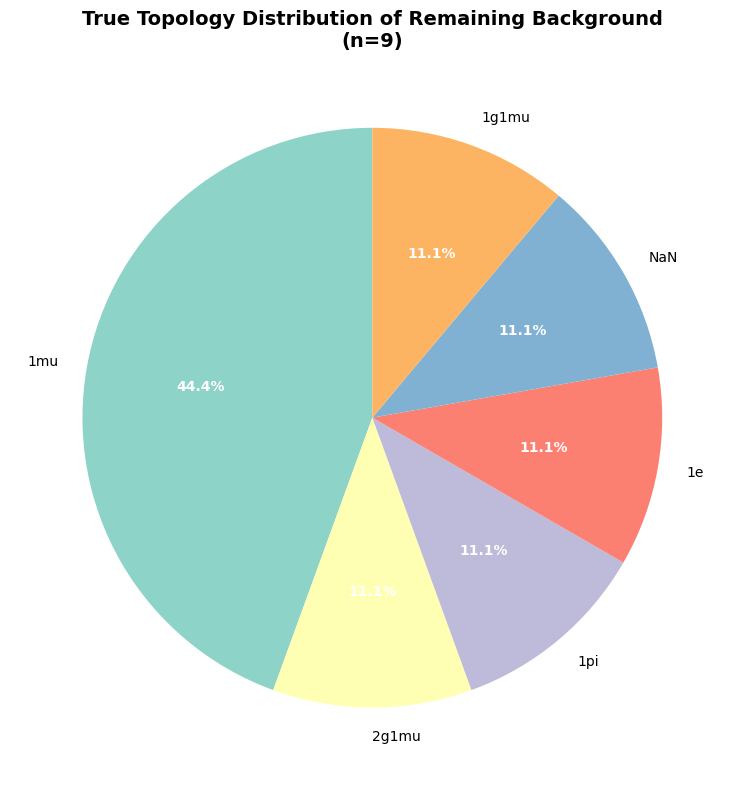


2. DETAILED INFORMATION FOR EACH REMAINING INTERACTION

Remaining Interaction #1 (Index 16430):
  Event ID: 2469005, Reco ID: 57
  True topology: 1mu
  Reco topology: 1g
  True ID: 39
  Interaction mode: 3
  Interaction type: 3
  True energy: 56234.80 MeV
  True PDG: 14
  Target (Atomic Number): 26

  PCA Analysis:
    PC1 angle w.r.t. beam: 9.79°
    Longitudinal spread (√λ₁): 17.13 cm
    Transverse major (√λ₂): 1.85 cm
    Transverse minor (√λ₃): 0.47 cm
    √λ₂/√λ₁ ratio: 0.1080
    √λ₃/√λ₁ ratio: 0.0273

  Reco Particles (Primary & Valid):
    Particle 0 (ID=105): PID=0, KE=155.2 MeV, dE/dx=2.46 MeV/cm, angle=4.09°, Eθ²=0.79 MeV·rad²

  Proximity Status:
    Has contact: False
    Min distance to other interactions: 1.34 cm

Remaining Interaction #2 (Index 24004):
  Event ID: 2473009, Reco ID: 51
  True topology: 2g1mu
  Reco topology: 1g
  True ID: 19
  Interaction mode: 10
  Interaction type: 10
  True energy: 1709.13 MeV
  True PDG: 14
  Target (Atomic Number): 18

  PCA Analy

In [26]:
# Analysis of Remaining Background after all cuts
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

print("=" * 80)
print("REMAINING BACKGROUND ANALYSIS")
print("=" * 80)
print(f"Total remaining interactions: {len(indices_of_remaining_backgrounds)}")
print(f"True NUEEL signals in remaining: {len([i for i in indices_of_remaining_backgrounds if i in indices_NUEEL])}")

# 1. True Topology Distribution (Pie Chart)
print("\n" + "=" * 80)
print("1. TRUE TOPOLOGY DISTRIBUTION")
print("=" * 80)

topology_counts = Counter([true_topology[i] if true_topology[i] != '' else 'NaN' 
                           for i in indices_of_remaining_backgrounds])

print("\nTopology counts:")
for topo, count in topology_counts.most_common():
    percentage = count / len(indices_of_remaining_backgrounds) * 100
    print(f"  {topo}: {count} ({percentage:.1f}%)")

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Set3(range(len(topology_counts)))
wedges, texts, autotexts = ax.pie(topology_counts.values(), 
                                    labels=topology_counts.keys(),
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)
ax.set_title(f'True Topology Distribution of Remaining Background\n(n={len(indices_of_remaining_backgrounds)})', 
             fontsize=14, fontweight='bold')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# 2. Detailed Information for Each Interaction
print("\n" + "=" * 80)
print("2. DETAILED INFORMATION FOR EACH REMAINING INTERACTION")
print("=" * 80)

for idx, i in enumerate(indices_of_remaining_backgrounds):
    print(f"\n{'='*60}")
    print(f"Remaining Interaction #{idx+1} (Index {i}):")
    print(f"{'='*60}")
    
    # Basic info
    print(f"  Event ID: {event_id[i]}, Reco ID: {reco_id[i]}")
    print(f"  True topology: {true_topology[i] if true_topology[i] != '' else 'NaN'}")
    print(f"  Reco topology: {reco_topology[i]}")
    
    print(f"  True ID: {true_id[i]}")
    print(f"  Interaction mode: {interaction_mode[i]}")
    print(f"  Interaction type: {interaction_type[i]}")
    print(f"  True energy: {true_energy[i]:.2f} MeV" if isinstance(true_energy[i], (int, float)) else f"  True energy: {true_energy[i]}")
    print(f"  True PDG: {true_pdg[i]}")
    print(f"  Target (Atomic Number): {target[i]}")
    
    # PCA variables
    pca_vars = reco_pca_variables[i]
    if isinstance(pca_vars, dict):
        eigenvalues = pca_vars['eigenvalues']
        pc1_angle = pca_vars['angle_wrt_beam']
    else:
        eigenvalues, eigenvectors, centroid = pca_vars
        th = -0.101
        beam_direction = np.array([0, np.sin(th), np.cos(th)])
        pc1 = eigenvectors[:, 0]
        cos_angle = np.abs(np.dot(pc1, beam_direction))
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        pc1_angle = np.arccos(cos_angle) * 180.0 / np.pi
    
    print(f"\n  PCA Analysis:")
    print(f"    PC1 angle w.r.t. beam: {pc1_angle:.2f}°")
    print(f"    Longitudinal spread (√λ₁): {np.sqrt(eigenvalues[0]):.2f} cm")
    print(f"    Transverse major (√λ₂): {np.sqrt(eigenvalues[1]):.2f} cm")
    print(f"    Transverse minor (√λ₃): {np.sqrt(eigenvalues[2]):.2f} cm")
    print(f"    √λ₂/√λ₁ ratio: {np.sqrt(eigenvalues[1])/np.sqrt(eigenvalues[0]):.4f}")
    print(f"    √λ₃/√λ₁ ratio: {np.sqrt(eigenvalues[2])/np.sqrt(eigenvalues[0]):.4f}")
    
    # Reco particle information
    print(f"\n  Reco Particles (Primary & Valid):")
    particle_list = reco_particle_info[i]
    primary_valid_count = 0
    
    for j, particle_dict in enumerate(particle_list):
        if particle_dict['primary'] and particle_dict['valid']:
            primary_valid_count += 1
            ke = particle_dict['reco_ke']
            angle = particle_dict['angle_wrt_beam']
            angle_rad = angle * np.pi / 180.0
            etheta2 = ke * (angle_rad ** 2)
            print(f"    Particle {j} (ID={particle_dict['particle_id']}): "
                  f"PID={particle_dict['particle_pid']}, "
                  f"KE={particle_dict['reco_ke']:.1f} MeV, "
                  f"dE/dx={particle_dict['start_dedx']:.2f} MeV/cm, "
                  f"angle={particle_dict['angle_wrt_beam']:.2f}°, "
                  f"Eθ²={etheta2:.2f} MeV·rad²")
    
    if primary_valid_count == 0:
        print(f"    (No primary & valid particles)")
    
    # Check proximity status if available
    if i in proximity_results:
        prox_info = proximity_results[i]
        print(f"\n  Proximity Status:")
        print(f"    Has contact: {prox_info['has_contact']}")
        print(f"    Min distance to other interactions: {prox_info['min_distance']:.2f} cm")
        if prox_info['has_contact']:
            print(f"    Contacts with {len(prox_info['contact_interactions'])} interactions:")
            for other_reco_id, dist in prox_info['contact_interactions'][:3]:  # Show first 3
                print(f"      - Reco ID {other_reco_id}: distance = {dist:.2f} cm")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

# Analysis of a special event

In [27]:
nan_event_id = 2465006
nan_reco_id = 1
nan_truth_id = 25

# Extract file number from event_id (first 4 digits)
file_number = int(str(nan_event_id)[:4])
file_path = f'/sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.{file_number:07d}.LARCV_spine.h5'

print(f"Event ID: {nan_event_id}")
print(f"File number extracted: {file_number}")
print(f"File path: {file_path}")

cfg1 = '''
base:
  verbosity: info
build:
  mode: both
  fragments: false
  particles: true
  interactions: true
  units: cm
io:
  reader:
    file_keys: DATA_PATH
    name: hdf5
'''.replace('DATA_PATH', file_path)

driver1 = Driver(yaml.safe_load(cfg1))
for data in driver1:
    if data['run_info'].event != nan_event_id:
        continue
    print(f"\nFound Event {data['run_info'].event}")
    for reco, truth in data['interaction_matches_r2t']:
        truth_id = truth.id if truth else ''
        if reco.id != nan_reco_id and truth_id != nan_truth_id:
            continue
        print(f"Reco ID: {reco.id}")
        print(f"Reco topology: {reco.topology}")
        print(f"Reco particle IDs: {reco.particle_ids}")
        print(f"Truth ID: {truth.id}")
        print(f"Truth particle IDs: {truth.particle_ids}")
        print(f"Reco vtx: {reco.vertex}")
        print(f"Reco start point: {reco.particles[0].start_point}")
        print(f"Truth vtx: {truth.vertex}")
        print(f"Interaction mode: {truth.interaction_mode}")
        print(f"Current type: {truth.current_type}")
        print(f"Target PDG: {truth.target}")
        
        print("\n" + "-" * 80)
        print("TRUTH PARTICLE DETAILS:")
        print("-" * 80)
        
        # Loop through all truth particles
        for i, truth_particle in enumerate(truth.particles):
            #continue
            print(f"\n  Truth Particle {i+1}:")
            print(f"    Particle ID: {truth_particle.id}")
            print(f"    PDG Code: {truth_particle.pdg_code}")
            print(f"    Parent PDG Code: {truth_particle.parent_pdg_code}")
            print(f"    Ancestor PDG Code: {truth_particle.ancestor_pdg_code}")
            print(f"    Creation Process: {truth_particle.creation_process}")
            print(f"    Parent Creation Process: {truth_particle.parent_creation_process}")
            print(f"    Ancestor Creation Process: {truth_particle.ancestor_creation_process}")
            print(f"    Track ID: {truth_particle.track_id}")
            print(f"    Parent Track ID: {truth_particle.parent_track_id}")
            print(f"    Ancestor Track ID: {truth_particle.ancestor_track_id}")
            print(f"    Energy Init: {truth_particle.energy_init:.2f} MeV")
            print(f"    Energy Deposit: {truth_particle.energy_deposit:.2f} MeV")
            print(f"    Is Primary: {truth_particle.is_primary}")
            print(f"    Group Primary: {truth_particle.group_primary}")
            print(dir(truth_particle))
        
        #break

    print("\n" + "=" * 80)
    break


Event ID: 2465006
File number extracted: 2465
File path: /sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.0002465.LARCV_spine.h5

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome054 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765396714}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.0002465.LARCV_spine.h5,
    name: hdf5}
build: {mode: both, f

# Detailed Analysis of True 1e Topology Events

2477001 60 99
1 1002.7912674328078
targ:  18
2477001 70 99
1 1002.7912674328078
targ:  18
2497007 46 1
1 2019.1688718710097
0 292.54254150390625
0 500.20819091796875
0 977.5440835410917
targ:  18
2522002 65 26
1 1686.466947517653
targ:  18
2529008 3 2
1 4041.5543688141424
0 7.905990923947033
targ:  18
2529008 10 2
1 4041.5543688141424
0 7.905990923947033
targ:  18
2537001 23 93
1 4206.115234375
1 34.22806362431621
0 40.7555046081543
0 6.639250933727728
1 5.470803430081343
targ:  18
DETAILED ANALYSIS OF TRUE 1e TOPOLOGY EVENTS

Total true 1e events: 560

--------------------------------------------------------------------------------
INTERACTION MODE DISTRIBUTION:
--------------------------------------------------------------------------------
  Mode 3: 349 (62.3%)
  Mode 4: 93 (16.6%)
  Mode 1: 68 (12.1%)
  Mode 10: 32 (5.7%)
  Mode 5: 15 (2.7%)
  Mode 7: 3 (0.5%)

--------------------------------------------------------------------------------
CURRENT TYPE DISTRIBUTION:
--------------

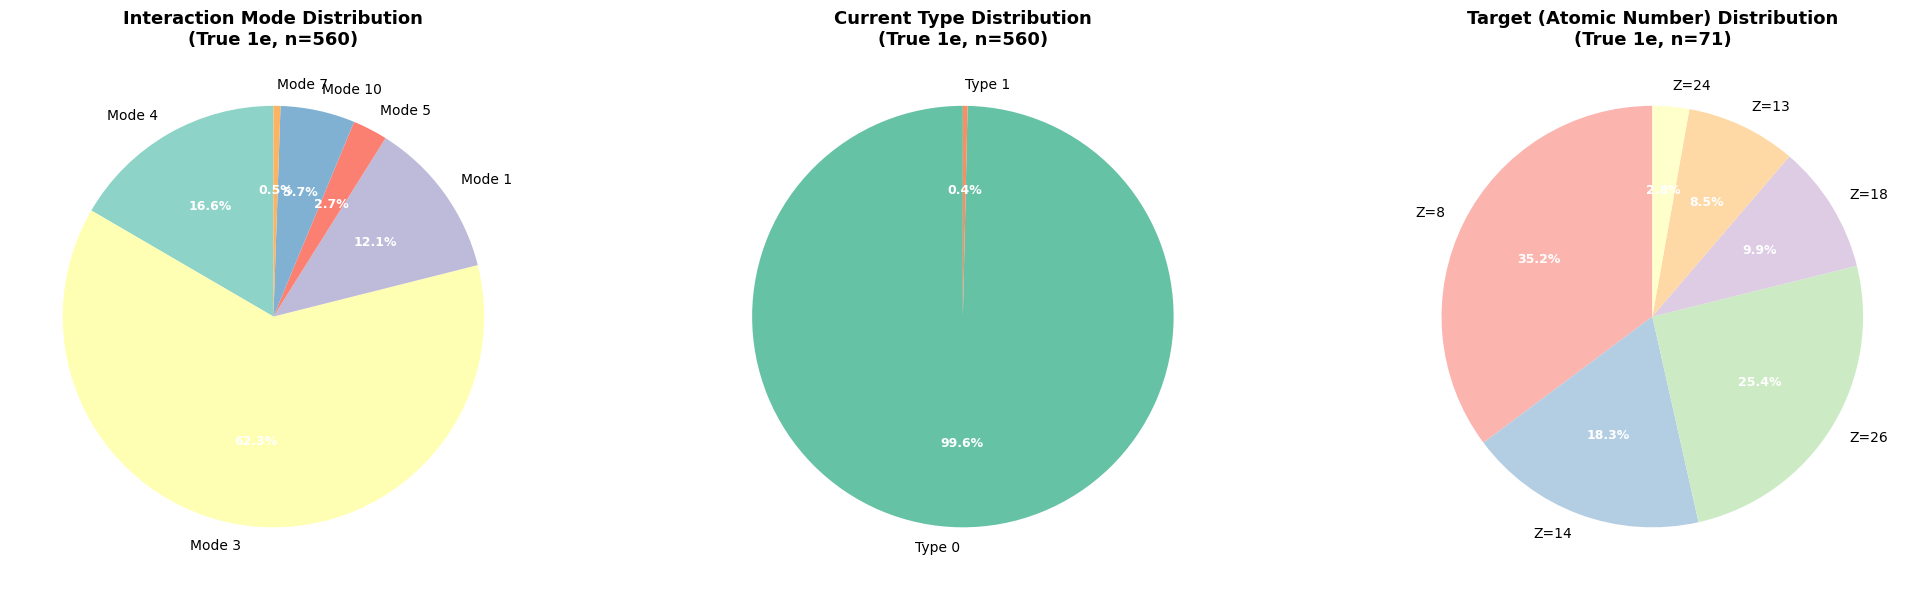


ANALYSIS COMPLETE


In [28]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Collect information for all true 1e topology events
interaction_mode_1e = []
current_type_1e = []
target_1e = []

# Iterate through all interactions
for i in range(len(true_topology)):
    if true_topology[i] == '1e':
        # Collect interaction mode
        mode = interaction_mode[i]
        interaction_mode_1e.append(mode)
        
        
        # Collect current type
        cur_type = current_type[i]
        current_type_1e.append(cur_type)
        
        # Collect target (atomic number)
        targ = target[i]
        if mode == 3:
            non_em_flag = False
            
            for p in true_particle_info[i]:
                if p['particle_pid']>1:
                    non_em_flag = True
            if not non_em_flag:
                #interaction_mode_1e.append(mode)
                pass
                if targ == 18:
                    print(event_id[i], reco_id[i], true_id[i])
                    for p in true_particle_info[i]:
                        print(p['particle_pid'], p['reco_ke'])
                    print("targ: ", targ)
                target_1e.append(targ)
                

# Count occurrences
mode_counts = Counter(interaction_mode_1e)
current_counts = Counter(current_type_1e)
target_counts = Counter(target_1e)

# Print statistics
print("=" * 80)
print("DETAILED ANALYSIS OF TRUE 1e TOPOLOGY EVENTS")
print("=" * 80)
print(f"\nTotal true 1e events: {len(interaction_mode_1e)}")

print("\n" + "-" * 80)
print("INTERACTION MODE DISTRIBUTION:")
print("-" * 80)
for mode, count in mode_counts.most_common():
    percentage = count / len(interaction_mode_1e) * 100
    print(f"  Mode {mode}: {count} ({percentage:.1f}%)")

print("\n" + "-" * 80)
print("CURRENT TYPE DISTRIBUTION:")
print("-" * 80)
for cur_type, count in current_counts.most_common():
    percentage = count / len(interaction_mode_1e) * 100
    print(f"  Current Type {cur_type}: {count} ({percentage:.1f}%)")

print("\n" + "-" * 80)
print("TARGET (ATOMIC NUMBER) DISTRIBUTION:")
print("-" * 80)
for targ, count in target_counts.most_common():
    percentage = count / len(interaction_mode_1e) * 100
    print(f"  Target Z={targ}: {count} ({percentage:.1f}%)")

# Create pie charts
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Pie chart 1: Interaction Mode
ax = axes[0]
colors = plt.cm.Set3(range(len(mode_counts)))
wedges, texts, autotexts = ax.pie(mode_counts.values(), 
                                    labels=[f'Mode {m}' for m in mode_counts.keys()],
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)
ax.set_title(f'Interaction Mode Distribution\n(True 1e, n={len(interaction_mode_1e)})', 
             fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

# Pie chart 2: Current Type
ax = axes[1]
colors = plt.cm.Set2(range(len(current_counts)))
wedges, texts, autotexts = ax.pie(current_counts.values(), 
                                    labels=[f'Type {t}' for t in current_counts.keys()],
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)
ax.set_title(f'Current Type Distribution\n(True 1e, n={len(interaction_mode_1e)})', 
             fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

# Pie chart 3: Target (Atomic Number)
ax = axes[2]
colors = plt.cm.Pastel1(range(len(target_counts)))
wedges, texts, autotexts = ax.pie(target_counts.values(), 
                                    labels=[f'Z={t}' for t in target_counts.keys()],
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)
ax.set_title(f'Target (Atomic Number) Distribution\n(True 1e, n={len(target_1e)})', 
             fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)